<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 07/01/2021<b>

In [1]:
# general libraries
import sys
import math
import operator
import itertools
import collections
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import unique
from numpy import argmax
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [2]:
data_directory = "../../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_cleaned_file = data_directory + "Numerical_Encoding_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Numerical_Encoding_Test_HR_Employee_Attrition.csv"

In [3]:
df_cleaned = pd.read_csv(TR_cleaned_file, sep=",") 

In [4]:
df_ts = pd.read_csv(TS_file , sep=",") 

In [5]:
df_cleaned.shape

(883, 24)

In [6]:
df_ts.shape

(219, 24)

<h2> Split dataset in Training and Test set </h2>

In [7]:
y = df_cleaned['Attrition']
df1 = df_cleaned.copy()
X = df1.drop('Attrition', axis=1)
print(X.shape)

(883, 23)


In [8]:
# summarize dataset
classes = unique(y)
total = len(y)
for c in classes:
    n_examples = len(y[y==c])
    percent = n_examples / total * 100
    print('> Class=%d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class=0 : 730/883 (82.7%)
> Class=1 : 153/883 (17.3%)


<h1> Imbalanced target variable </h1>

Since our training set is highly unbalanced with respect to the target attribute object of the classification (Attrition=Yes: 153 (17.33%), Attrition=No:730 (82.67%)), we try to solve this problem using three resampling techniques: 

- **StratifiedKFold**: split a dataset randomly, in such a way that maintains the same class distribution in each fold.
- **oversampling**: duplicates examples from minority class;  ==> may lead to overfitting
- **undersampling**: deletes or filters examples from the majority class.  ==> may lead to underfitting

In [9]:
def plot_confusion_matrix(cm, classes, normalize, title, cmap):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # plt.clf()

<h2> Stratified 70-30 holdout </h2>

In [10]:
tmp_X_train, tmp_X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

<h2> MinMaxScaler </h2>

In [11]:
scaler = MinMaxScaler().fit(tmp_X_train)
X_train = scaler.transform(tmp_X_train)
X_test = scaler.transform(tmp_X_test)

In [12]:
n_splits = 3  # StratifiedKFold splits
no_skill = len(y[y==1]) / len(y)  # PR_curve random model AUC
sampling_methods_info = {}

In [13]:
def report(results, n_top, scoring, scorings):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        # retrieeve best i-th model's score index
        candidates = np.flatnonzero(results['rank_test_score'] == i)  # returns array([score_index])
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean training score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_train_score'][candidate],
                  results['std_train_score'][candidate]))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations


def report_multiple(results, n_top, scoring, scorings):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_' + str(scoring)] == i)
        for candidate in candidates:
            """print("Model with rank: {0}".format(i))
            print("Mean training score:", end = '')
            for s in scorings:
                print( "   " + s + ": {0:.3f} (std: {1:.3f})".format(
                      results['mean_train_' + s][candidate],
                      results['std_train_' + s][candidate]), end = '')
            

            print("Mean validation score:", end = '')
            for s in scorings:
                print( "   " + s + ": {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_' + s][candidate],
                      results['std_test_' + s][candidate]), end = '')

            print("Parameters: {0}".format(results['params'][candidate]))
            print("")"""
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

In [14]:
def update_best_model_info(resampling_label, models_u, roc_auc_models_u_val, precision_recall_auc_models_u_val,
                           best_model_index_u, best_ap_model_index_u, models_thresh, best_thresh, 
                           ap_best_thresh, scoring, refit):
    # keep_track_of_best_model_info
    sampling_methods_info[resampling_label] = {}
    cnf = models_u[best_model_index_u]
    sampling_methods_info[resampling_label]["model_param"] = {}
    sampling_methods_info[resampling_label]["model_param"]["n_neighbors"] = cnf.n_neighbors
    sampling_methods_info[resampling_label]["model_param"]["weights"] = cnf.weights
    sampling_methods_info[resampling_label]["model_param"]["p"] = cnf.p
    sampling_methods_info[resampling_label]["roc_auc_best_model_index"] = best_model_index_u
    sampling_methods_info[resampling_label]["roc_auc"] = roc_auc_models_u_val
    sampling_methods_info[resampling_label]["ap_best_model_index"] = best_ap_model_index_u
    sampling_methods_info[resampling_label]["ap"] = precision_recall_auc_models_u_val
    sampling_methods_info[resampling_label]["model_threshold"] = models_thresh
    sampling_methods_info[resampling_label]["roc_auc_threshold"] = best_thresh
    sampling_methods_info[resampling_label]["pr_ap_threshold"] = ap_best_thresh
    sampling_methods_info[resampling_label]["scoring"] = scoring
    sampling_methods_info[resampling_label]["refit"] = refit

In [15]:
def get_decision_tree_classifier_params(sampler, resampling_label):
    param_list = {'n_neighbors': list(range(2, 51)),
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]
                 }
    new_params = {'kneighborsclassifier__' + key: param_list[key] for key in param_list}
    return sampler, new_params

In [16]:
def to_labels(pos_probs, threshold):
    # apply threshold to positive probabilities to create labels
    return (pos_probs >= threshold).astype('int')

In [17]:
def get_model_thresholds(model):
    model.fit(X_train, y_train)
    # predict probabilities
    yhat = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.001)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    print( 'ModelThreshold=%.3f, F-measure=%.5f ' % (thresholds[ix], scores[ix]))
    return thresholds[ix]

In [18]:
def my_grid_search(sampler, resampling_label, scoring, refit):    

    # declare K-Fold validation to use
    # declare model to use
    # initialize sampler and GridSearchCV's hyperparameters to tune
    cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    model =  KNeighborsClassifier()  #KNN
    sampler, new_params = get_decision_tree_classifier_params(sampler, resampling_label)
    
    # declare a imbalance Pipeline to use 
    # (I'm using imblearn.pipeline since it allows to performe both K-Fold (resampling only on TR's folds)
    # and model's tuning, at same time)
    if sampler != "":
        imba_pipeline = imbmake_pipeline(sampler, model)
    imba_pipeline = imbmake_pipeline(model)

    # perform GridSearchCV (hyperparameters tuning)
    grid_search = GridSearchCV(imba_pipeline, param_grid=new_params, cv=cv, scoring=scoring, 
                                 refit=refit, n_jobs=-1, verbose=1, return_train_score=True)
    # build inductive model on TR
    grid_search.fit(X_train, y_train)
    results = grid_search.cv_results_
    cnfs = report_multiple(results, n_top=3, scoring=refit, scorings=scoring)
    
    # train_models:
    if sampler != "":
        x_u_train_resampled, y_u_train_resampled = sampler.fit_resample(X_train, y_train)
    else:
        x_u_train_resampled, y_u_train_resampled = X_train, y_train
        
    models_u = []
    y_pred_vals_u = []
    y_pred_trains_u = []
    hyper_ps = grid_search.cv_results_
    model_index = 0
    for cnf in cnfs.values():
        n_neighbors = cnf['kneighborsclassifier__n_neighbors']
        weights = cnf['kneighborsclassifier__weights']
        p = cnf['kneighborsclassifier__p']
        clf = KNeighborsClassifier(n_neighbors=n_neighbors, 
                                     weights=weights,
                                     p=p)
        clf = clf.fit(x_u_train_resampled, y_u_train_resampled)
        models_u.append(clf)
        y_pred = clf.predict(X_test)
        y_pred_tr = clf.predict(x_u_train_resampled)
        y_pred_vals_u.append(y_pred)
        y_pred_trains_u.append(y_pred_tr)


    # test_models
    roc_auc_models_u_val = []  # models' TS ROC_AUC 
    precision_recall_auc_models_u_val = []  # models' TS PRECISION_RECALL_AUC
    for i in range(0, len(cnfs)):
        fpr, tpr, thresholds = roc_curve(y_u_train_resampled, y_pred_trains_u[i])
        roc_auc = auc(fpr, tpr)
        roc_auc = roc_auc_score(y_u_train_resampled, y_pred_trains_u[i], average="weighted")
        print("model {}".format(i))
        print('Train Accuracy %s' % accuracy_score(y_u_train_resampled, y_pred_trains_u[i]))
        print('Train Precision %s' % precision_score(y_u_train_resampled, y_pred_trains_u[i], average="weighted"))
        print('Train Recall %s' % recall_score(y_u_train_resampled, y_pred_trains_u[i], average="weighted"))
        print('Train F1-score %s' % f1_score(y_u_train_resampled, y_pred_trains_u[i], average="weighted"))
        print('Train F2-score %s' % fbeta_score(y_u_train_resampled, y_pred_trains_u[i], average="weighted",
                                               beta=2))
        print("Train roc_auc: {}".format(roc_auc))
        cm = confusion_matrix(y_u_train_resampled, y_pred_trains_u[i])
        plot_confusion_matrix(cm, models_u[i].classes_, False, "TR's confusion matrix for model %d" %\
                              (i), plt.cm.Blues)
        plt.show()

        roc_auc = roc_auc_score(y_test, y_pred_vals_u[i], average="weighted")
        roc_auc_models_u_val.append(roc_auc)
        print("Validation roc_auc: {}".format(roc_auc))
        
        pr_ap = average_precision_score(y_test, y_pred_vals_u[i], average="weighted")
        precision_recall_auc_models_u_val.append(pr_ap)
        print("Validation precision_recall_ap: {}".format(pr_ap))
        
        print('\nValidation Accuracy %s' % accuracy_score(y_test, y_pred_vals_u[i]))
        print('Validation Precision %s' % precision_score(y_test, y_pred_vals_u[i], average="weighted"))
        print('Validation Recall %s' % recall_score(y_test, y_pred_vals_u[i], average="weighted"))
        print('Validation F1-score %s' % f1_score(y_test, y_pred_vals_u[i], average="weighted"))
        print('Validation F2-score %s' % fbeta_score(y_test, y_pred_vals_u[i], average="weighted", beta=2))
        print(classification_report(y_test, y_pred_vals_u[i]))
        cm = confusion_matrix(y_test, y_pred_vals_u[i])
        plot_confusion_matrix(cm, models_u[i].classes_, False, "VS' confusion matrix for model %d" %\
                              (i), plt.cm.Blues)
        plt.show()
        print('Parameters model %s and resampling_label=%s: n_neighbors=%s, weights=%s, p=%s"' % 
              (i, resampling_label, models_u[i].n_neighbors, models_u[i].weights, models_u[i].p))
    
    # get_best_model_index based on Precision_Recall_AP
    for i in range(0,len(cnfs)):
        print("model {} - precision_recall_ap: {}".format(i, precision_recall_auc_models_u_val[i]))
    best_pr_ap = max(precision_recall_auc_models_u_val)
    best_ap_model_index_u = precision_recall_auc_models_u_val.index(best_pr_ap)
    print("\nBEST MODEL INDEX = %d" % best_ap_model_index_u)

        
    # get_best_model_index based on ROC_AUC
    for i in range(0,len(cnfs)):
        print("model {} - roc_auc: {}".format(i, roc_auc_models_u_val[i]))
    best_roc_auc = max(roc_auc_models_u_val)
    best_model_index_u = roc_auc_models_u_val.index(best_roc_auc)
    print("\nBEST MODEL INDEX = %d" % best_model_index_u)
    
    models_thresh = get_model_thresholds(models_u[best_model_index_u])
        
    # draw_best_model_precision_recall_curve
    plt.figure(figsize=(8, 5))
    precision, recall, ap_thresholds = precision_recall_curve(y_test, y_pred_vals_u[best_model_index_u])
    # convert to f-measure
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f-measure
    ix = argmax(fscore)
    print( ' Best Threshold=%f, F-measure=%.3f ' % (ap_thresholds[ix], fscore[ix]))
    ap_best_thresh = ap_thresholds[ix]
    plt.plot(precision, recall, label='PR curve (AP=%0.4f)' %\
             (precision_recall_auc_models_u_val[best_model_index_u]))
        
    # calculate the no skill line as the proportion of the positive class
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], 'k--', color="red", label='Random model') 
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="upper right", fontsize=14, frameon=False)
    plt.title("Model %d's PR AP(average precision)" % best_model_index_u)
    plt.show()


    # draw_best_model_roc_auc
    plt.figure(figsize=(8, 5))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_vals_u[best_model_index_u])
    # Youden’s J statistic 
    J = tpr - fpr
    # locate best threshold's index
    ix = argmax(J)
    best_thresh = thresholds[ix]
    print( ' Best Threshold=%f ' % (best_thresh))
    plt.plot(fpr, tpr, label='ROC curve (AUC=%0.4f)' % (roc_auc_models_u_val[best_model_index_u]))
        
    plt.plot([0, 1], [0, 1], 'k--', color="red", label='Random model') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.tick_params(axis='both', which='major')
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.title("Model %d's ROC AUC" % best_model_index_u)
    plt.show()
    
    # keap track of best model's hyperparameters
    update_best_model_info(resampling_label, models_u, roc_auc_models_u_val, precision_recall_auc_models_u_val,\
                          best_model_index_u, best_ap_model_index_u,  models_thresh, best_thresh, \
                          ap_best_thresh, scoring, refit)
    
    return models_u, roc_auc_models_u_val, precision_recall_auc_models_u_val, best_model_index_u,\
                                                                                    best_ap_model_index_u

<h2>Plain TR</h2>

In [19]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [20]:
scoring_base = ["recall"]
scoring_pool = ["f1", "roc_auc", "precision", "f1_weighted", "average_precision", "roc_auc_ovo_weighted"] 
refit_pool = ["recall", "f1", "roc_auc", "f1_weighted", "average_precision", "roc_auc_ovo_weighted"]

In [21]:
scoring_sets = set()
for s in scoring_pool:
    # scoring = scoring_base + list(powerset(scoring_pool))
    tmp_list = list(powerset(scoring_pool))
    max_set_size = len(scoring_pool)
    for tmp_tuple in tmp_list:
        tmp_tuple += (scoring_base[0],) 
        scoring_sets.add(tmp_tuple)

scoring=['f1', 'precision', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   10.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


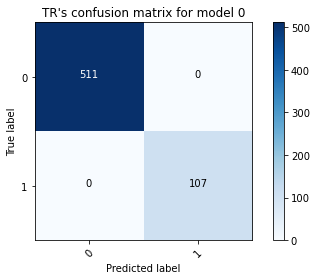

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


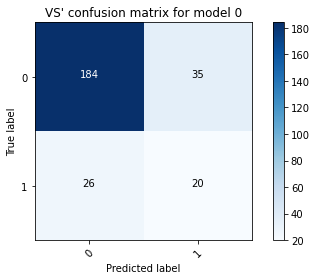

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


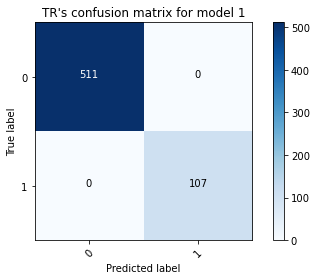

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


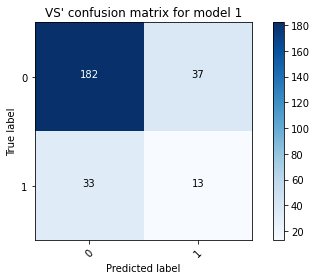

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


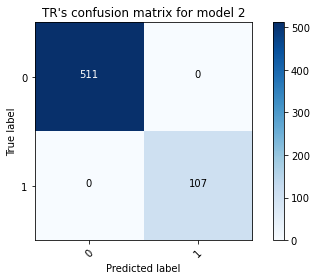

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


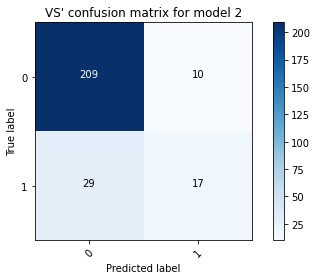

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


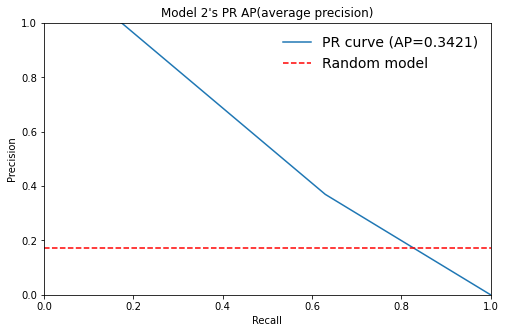

 Best Threshold=1.000000 


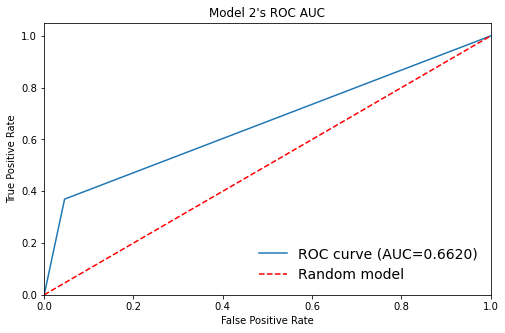

scoring=['precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


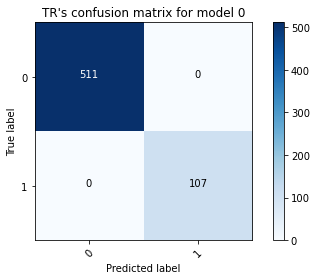

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


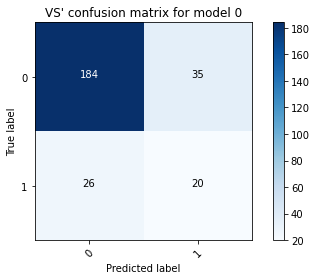

Parameters model 0 and resampling_label=scoring=['precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


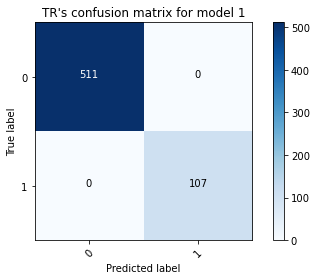

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


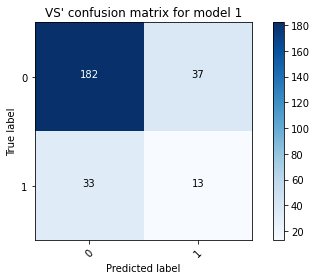

Parameters model 1 and resampling_label=scoring=['precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


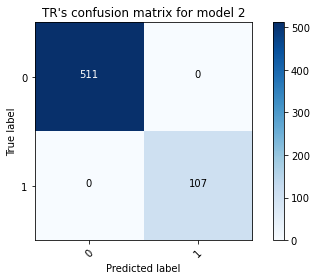

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


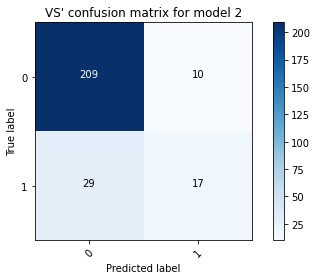

Parameters model 2 and resampling_label=scoring=['precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


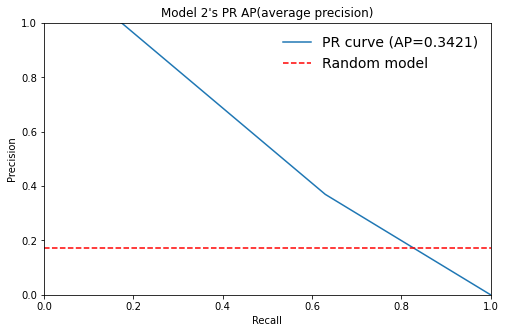

 Best Threshold=1.000000 


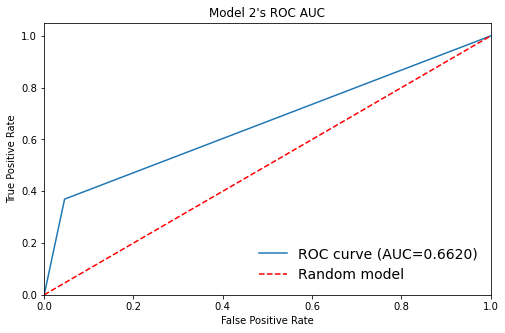

scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.9s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


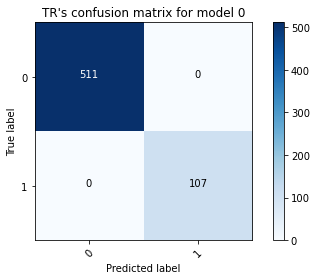

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


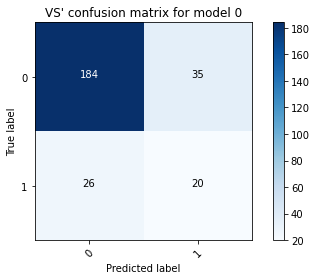

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


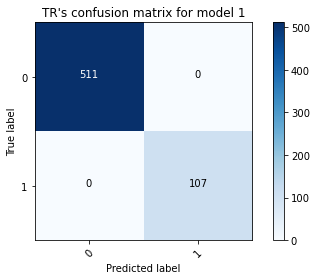

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


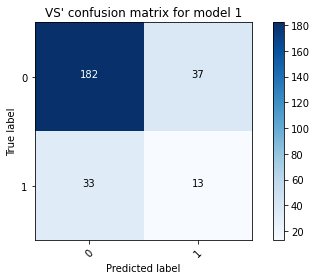

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


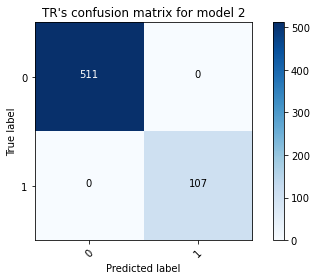

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


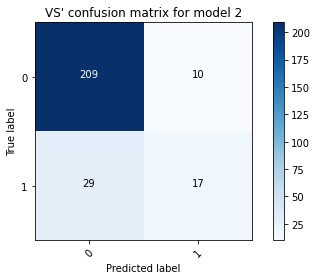

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


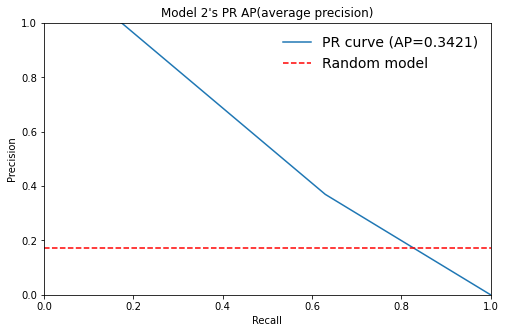

 Best Threshold=1.000000 


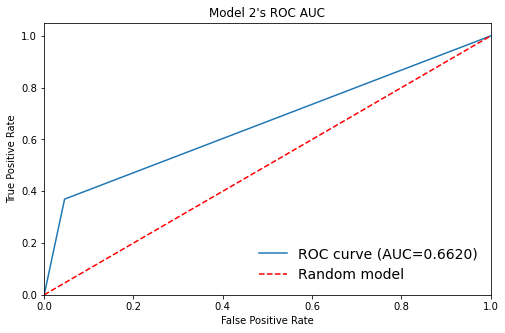

scoring=['f1', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   17.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


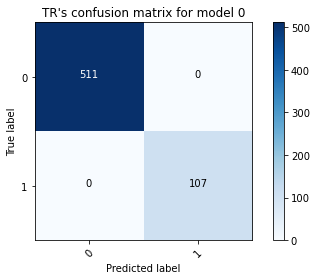

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


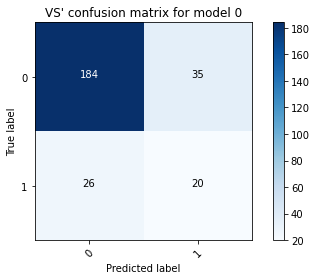

Parameters model 0 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


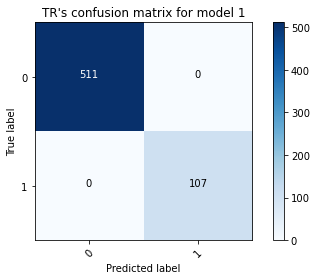

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


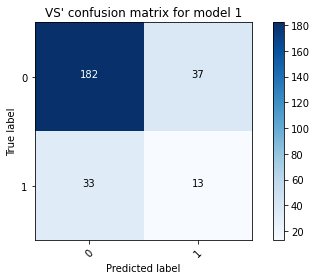

Parameters model 1 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


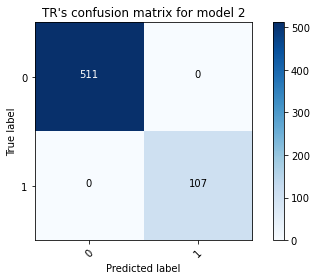

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


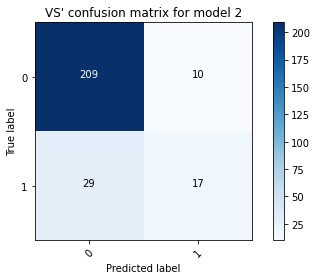

Parameters model 2 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


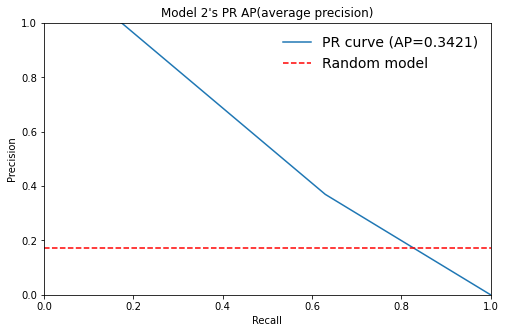

 Best Threshold=1.000000 


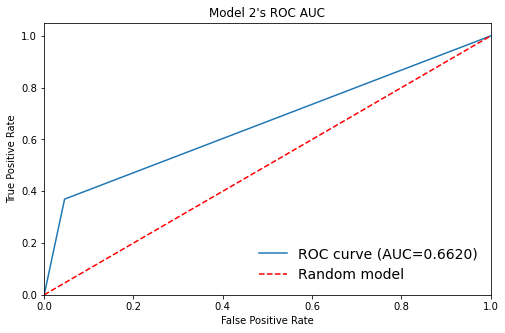

scoring=['f1', 'precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   12.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   12.9s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


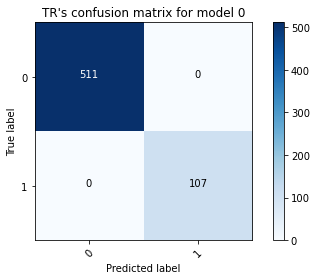

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


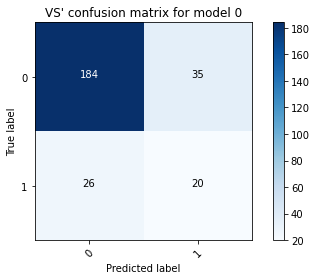

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


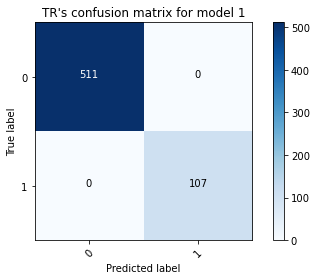

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


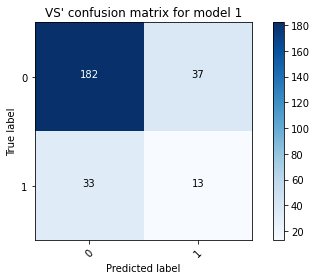

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


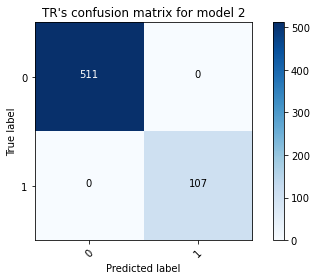

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


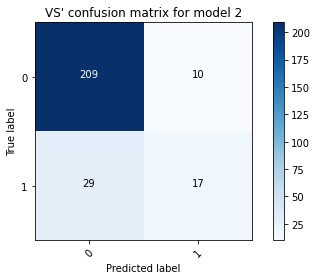

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


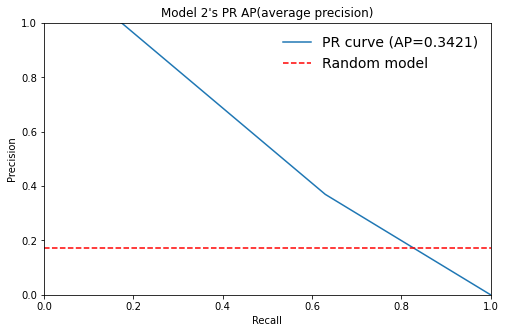

 Best Threshold=1.000000 


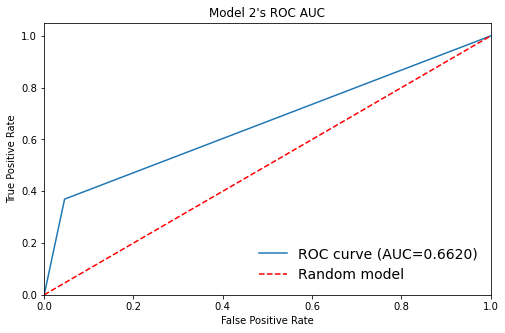

scoring=['f1', 'roc_auc', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   21.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


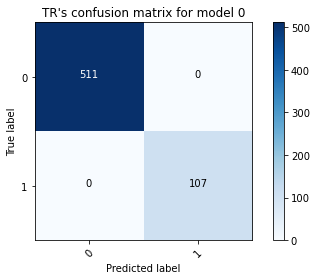

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


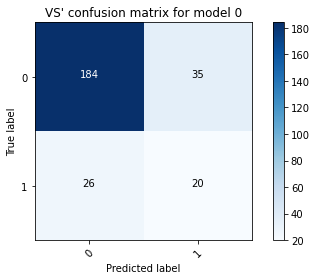

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


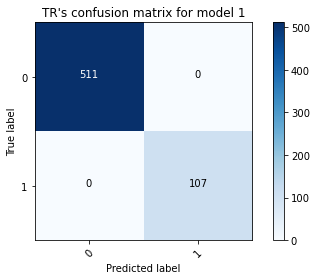

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


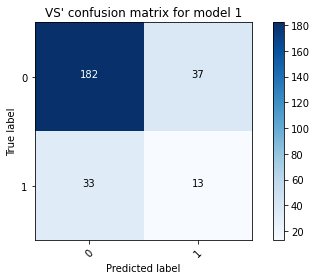

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


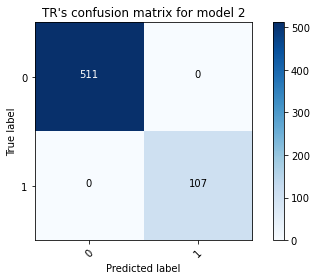

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


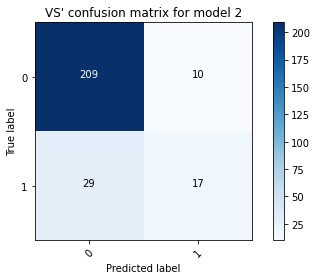

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


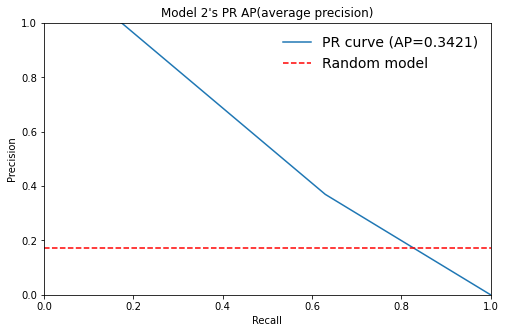

 Best Threshold=1.000000 


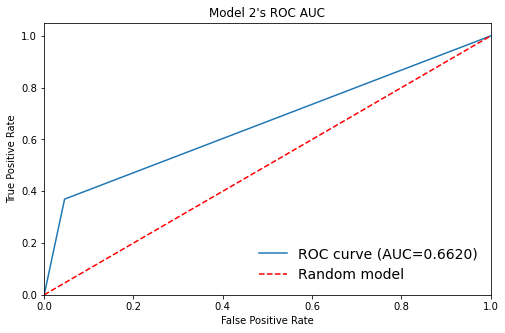

scoring=['precision', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   14.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   14.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


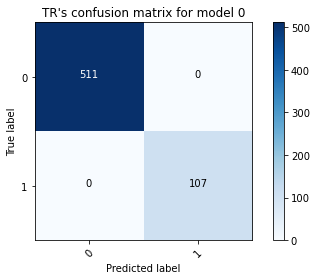

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


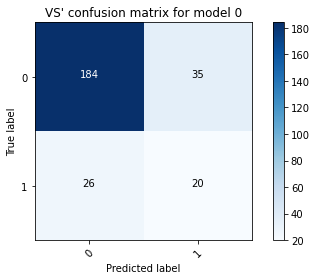

Parameters model 0 and resampling_label=scoring=['precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


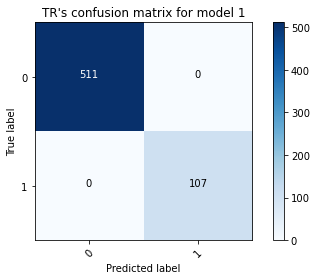

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


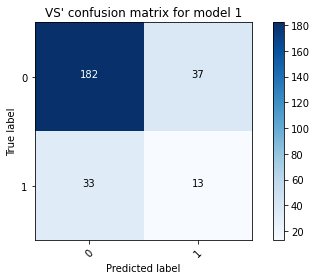

Parameters model 1 and resampling_label=scoring=['precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


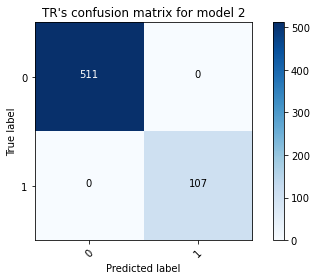

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


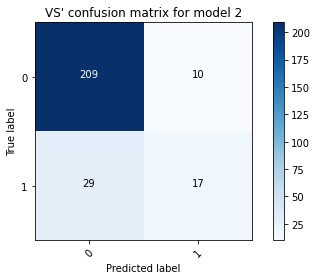

Parameters model 2 and resampling_label=scoring=['precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


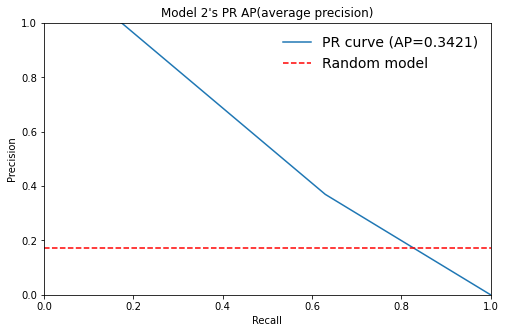

 Best Threshold=1.000000 


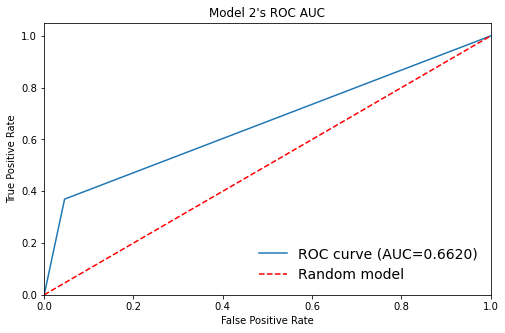

scoring=['roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.9s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


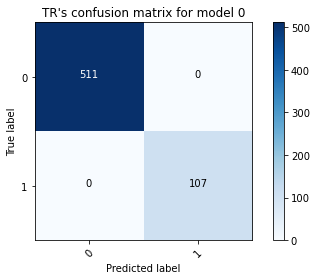

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


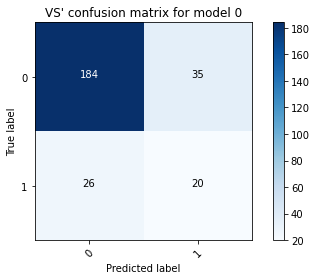

Parameters model 0 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


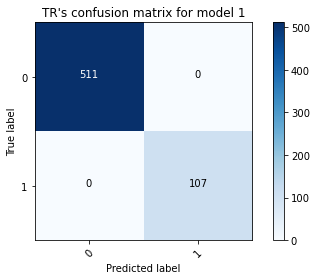

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


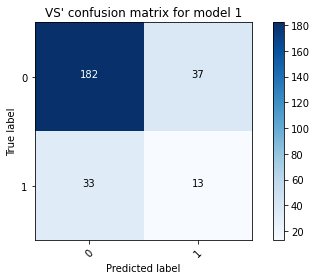

Parameters model 1 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


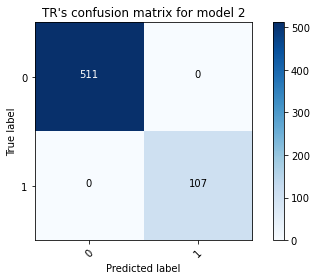

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


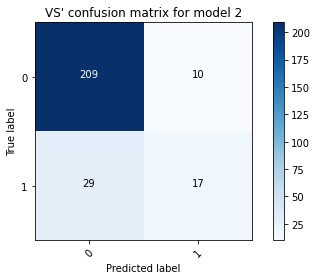

Parameters model 2 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


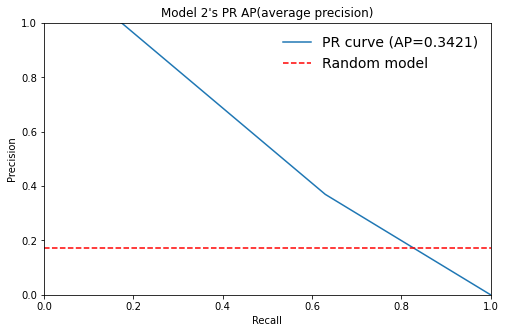

 Best Threshold=1.000000 


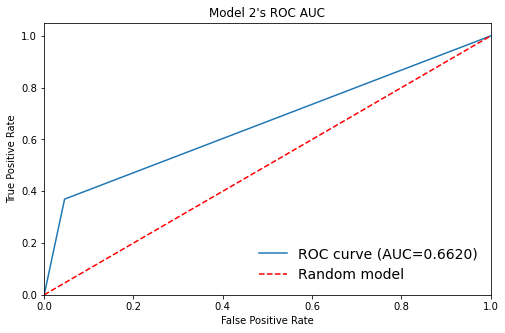

scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   28.2s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


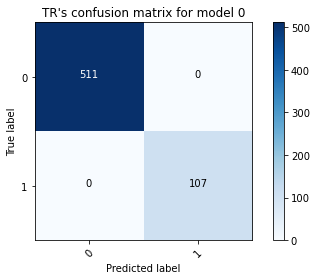

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


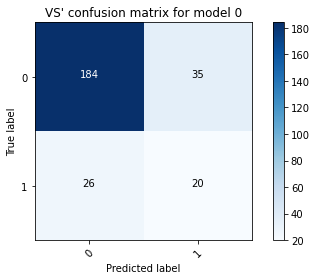

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


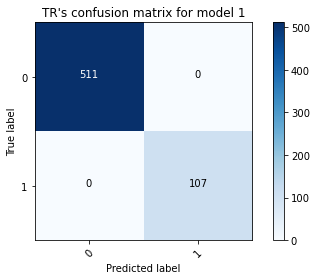

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


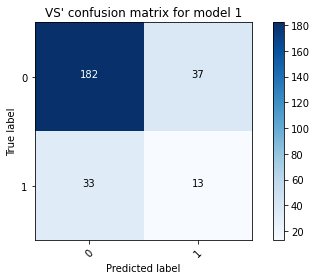

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


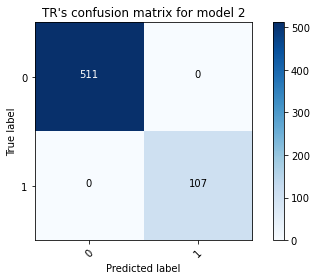

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


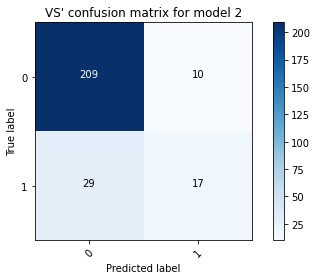

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


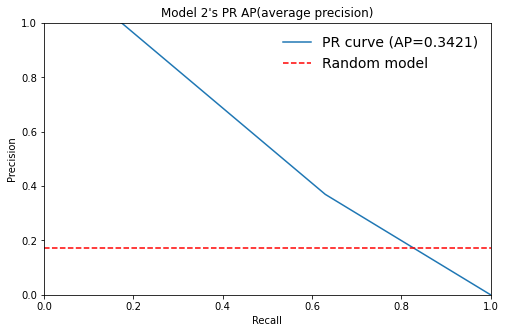

 Best Threshold=1.000000 


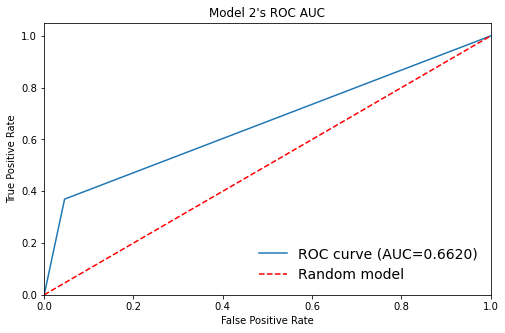

scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   33.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


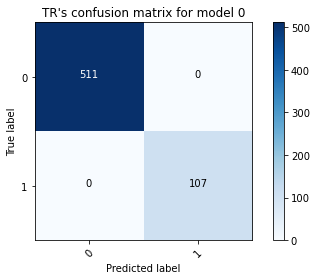

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


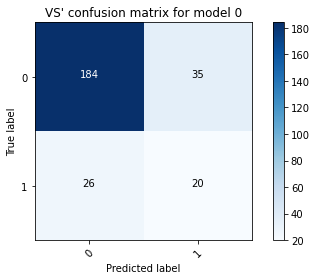

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


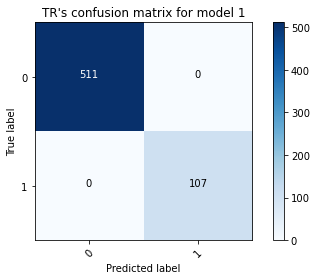

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


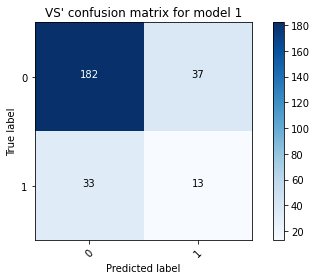

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


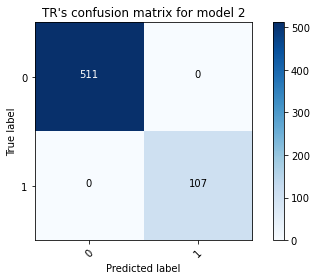

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


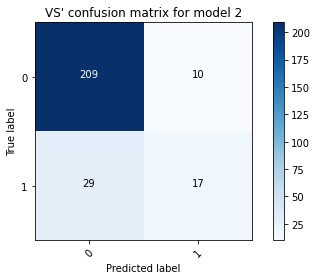

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


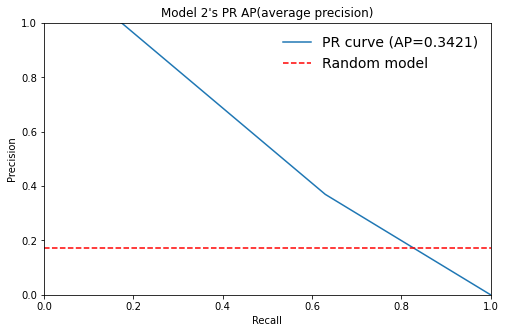

 Best Threshold=1.000000 


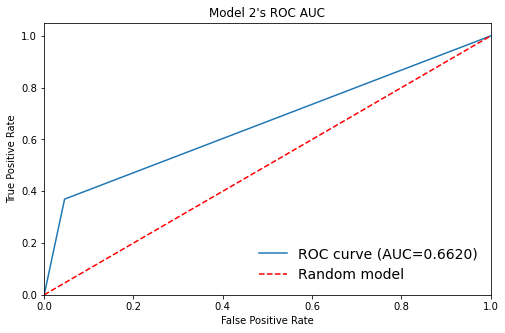

scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   29.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


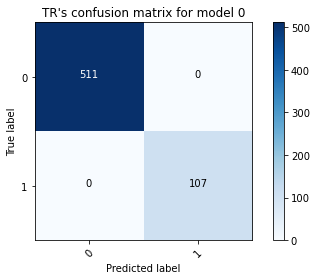

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


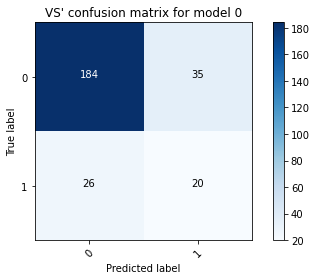

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


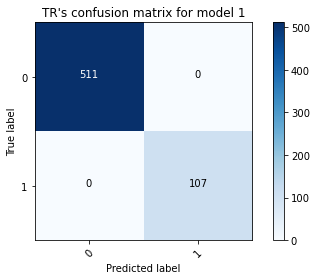

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


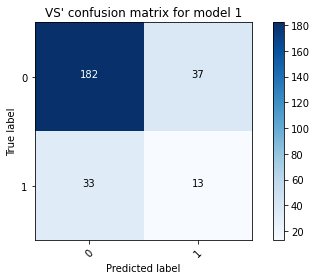

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


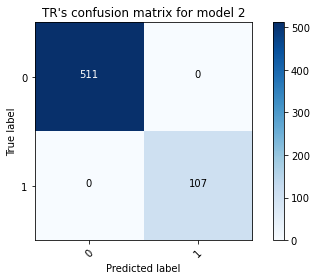

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


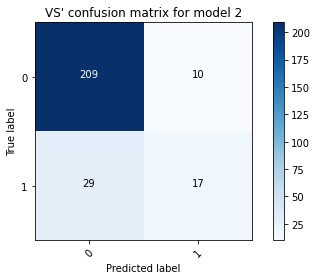

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


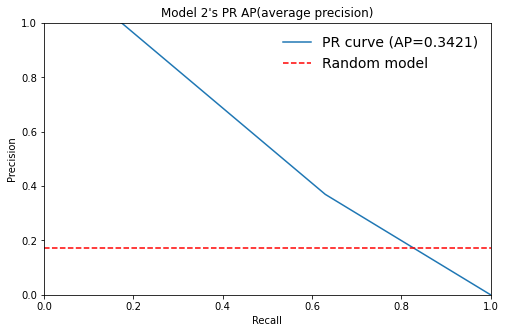

 Best Threshold=1.000000 


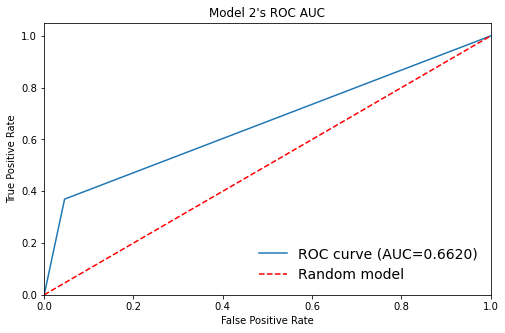

scoring=['average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   24.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   24.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


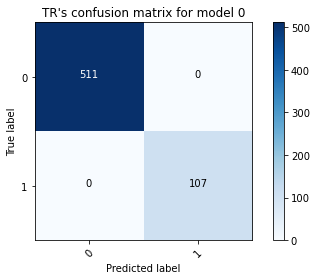

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


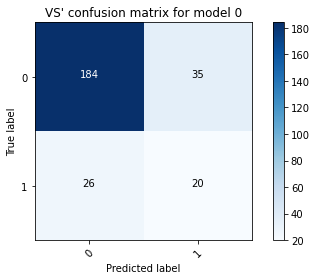

Parameters model 0 and resampling_label=scoring=['average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


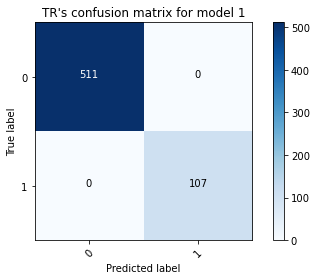

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


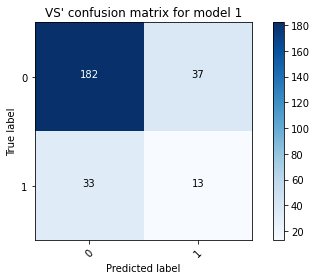

Parameters model 1 and resampling_label=scoring=['average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


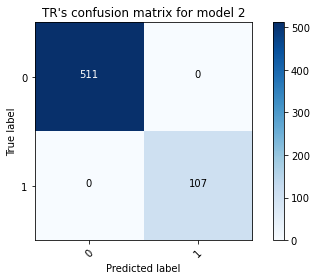

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


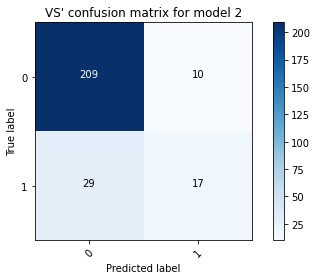

Parameters model 2 and resampling_label=scoring=['average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


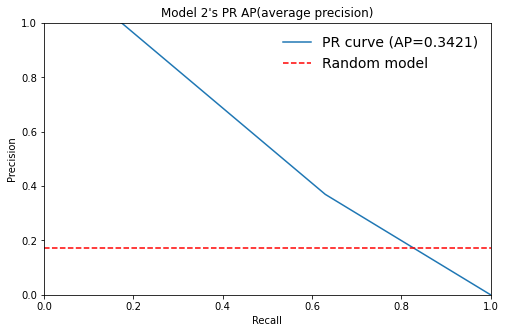

 Best Threshold=1.000000 


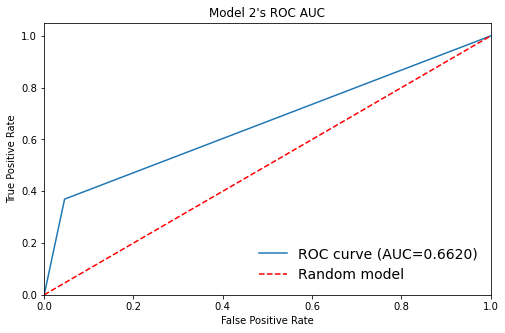

scoring=['f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


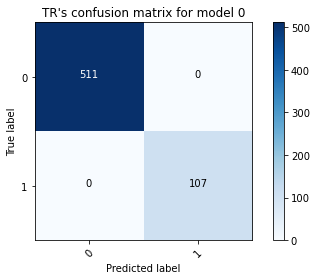

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


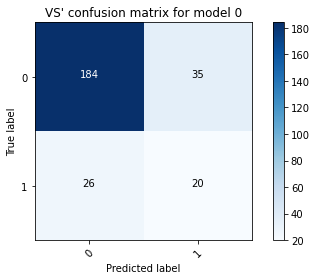

Parameters model 0 and resampling_label=scoring=['f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


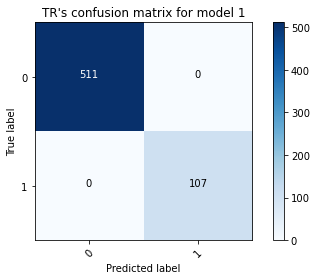

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


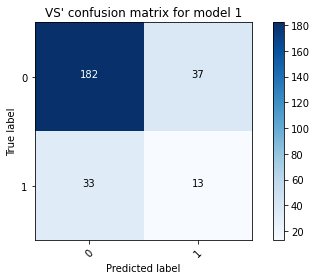

Parameters model 1 and resampling_label=scoring=['f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


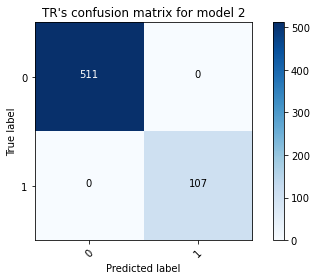

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


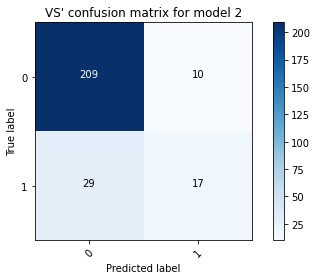

Parameters model 2 and resampling_label=scoring=['f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


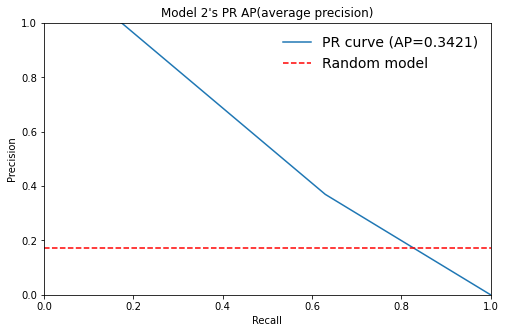

 Best Threshold=1.000000 


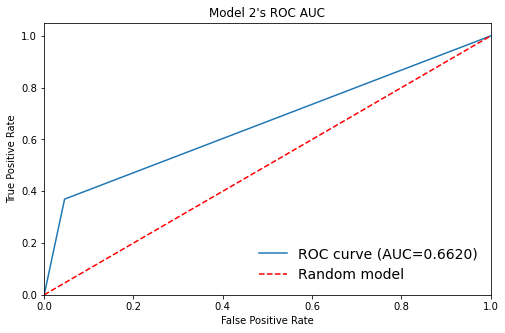

scoring=['f1', 'roc_auc', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.1s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


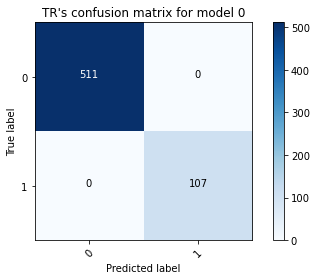

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


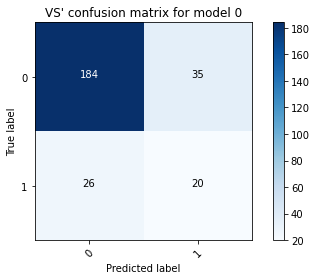

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


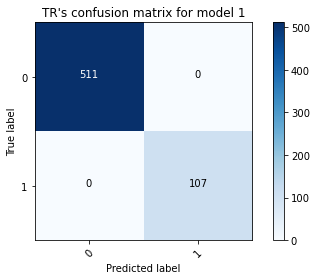

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


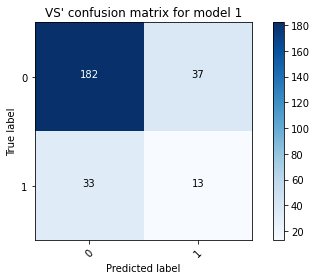

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


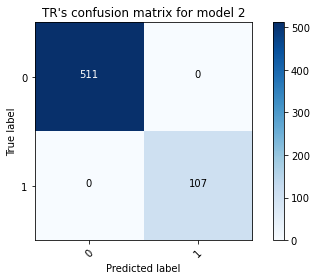

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


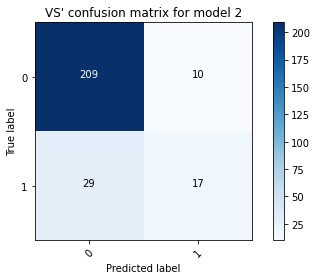

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


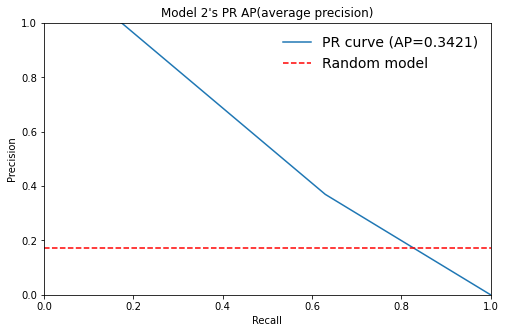

 Best Threshold=1.000000 


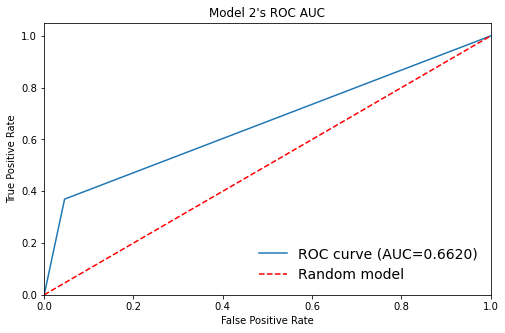

scoring=['f1', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


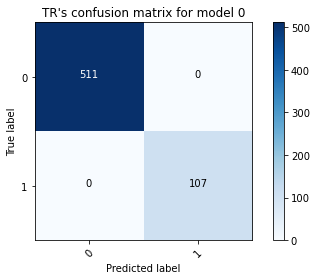

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


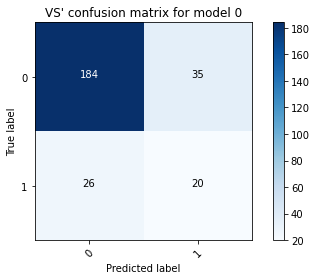

Parameters model 0 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


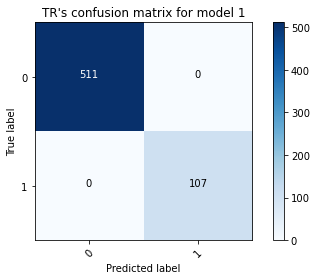

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


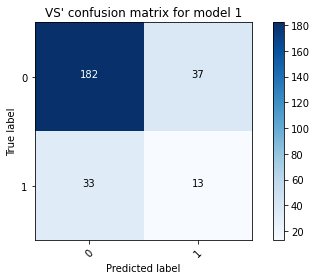

Parameters model 1 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


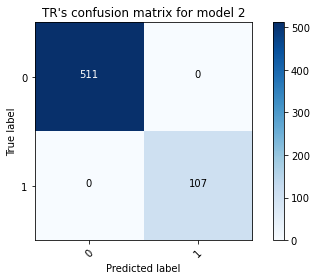

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


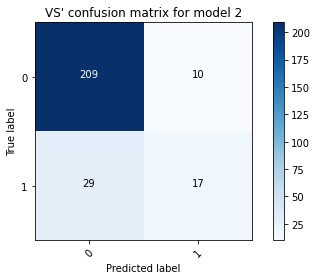

Parameters model 2 and resampling_label=scoring=['f1', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


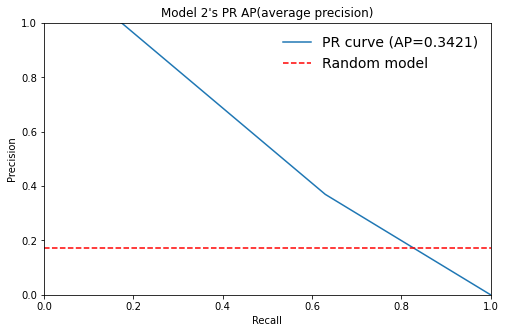

 Best Threshold=1.000000 


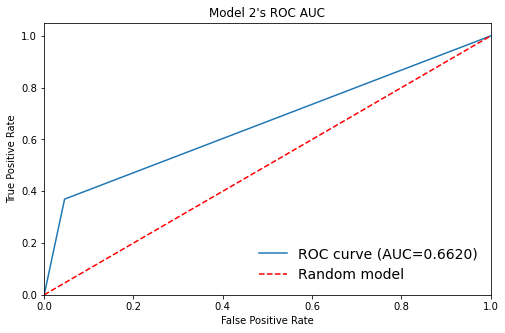

scoring=['average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   20.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


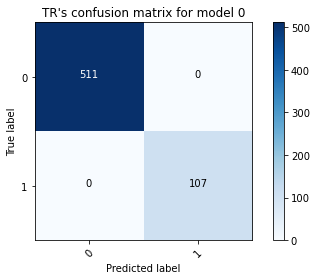

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


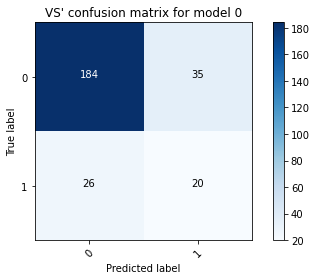

Parameters model 0 and resampling_label=scoring=['average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


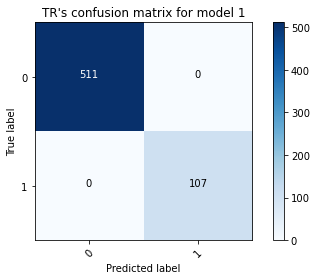

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


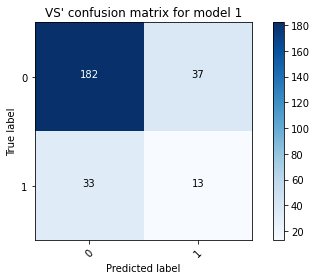

Parameters model 1 and resampling_label=scoring=['average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


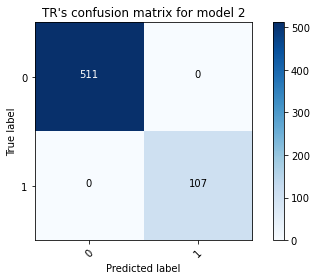

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


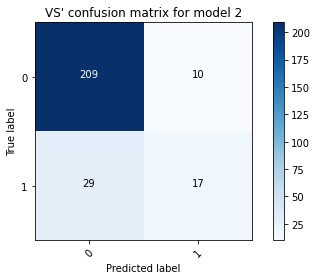

Parameters model 2 and resampling_label=scoring=['average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


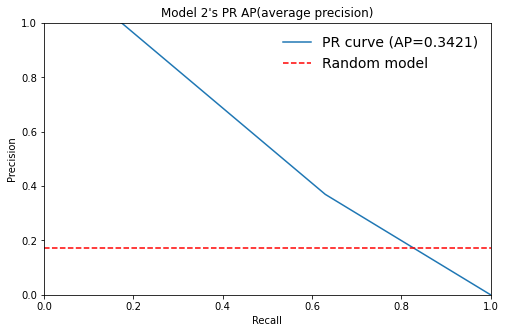

 Best Threshold=1.000000 


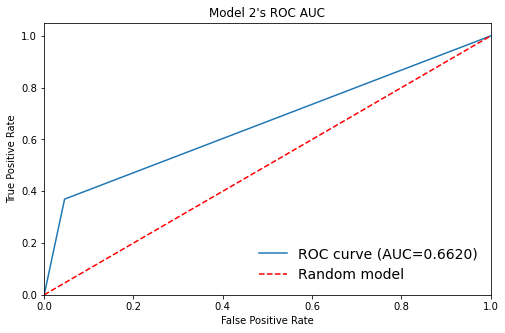

scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   22.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   22.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


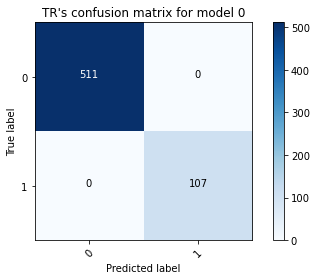

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


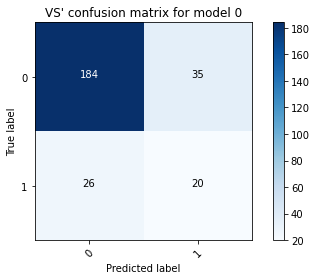

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


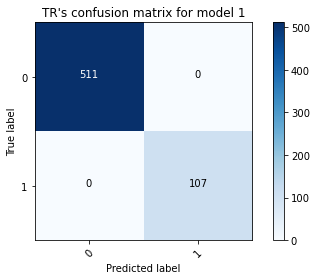

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


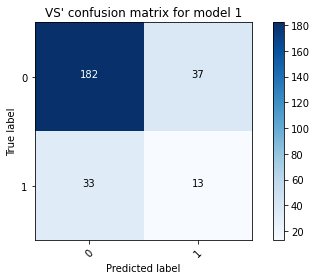

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


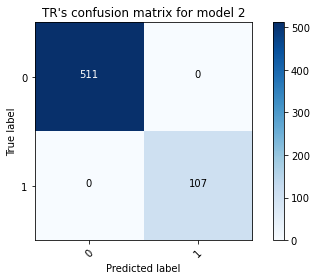

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


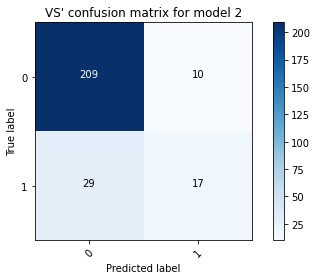

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


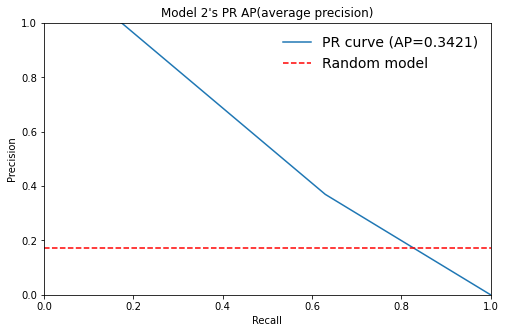

 Best Threshold=1.000000 


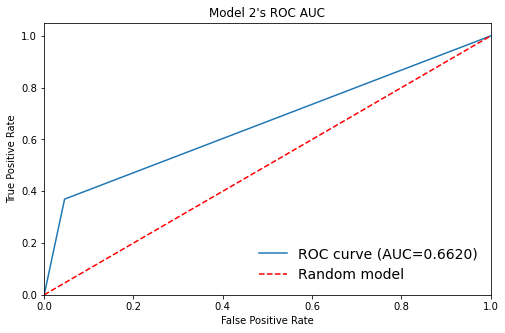

scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   22.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


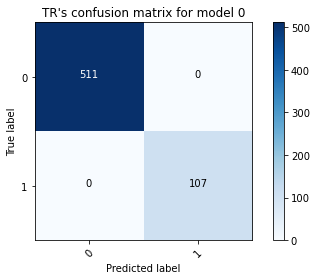

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


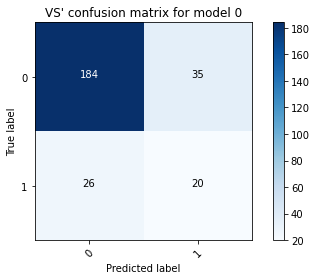

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


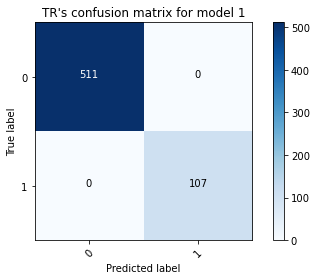

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


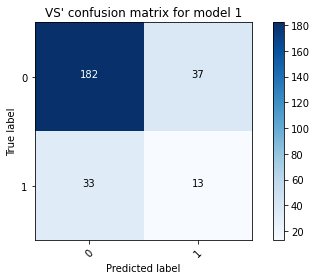

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


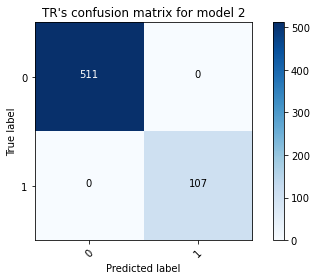

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


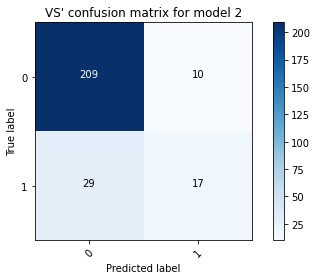

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


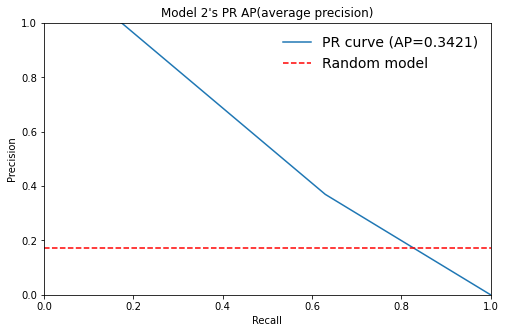

 Best Threshold=1.000000 


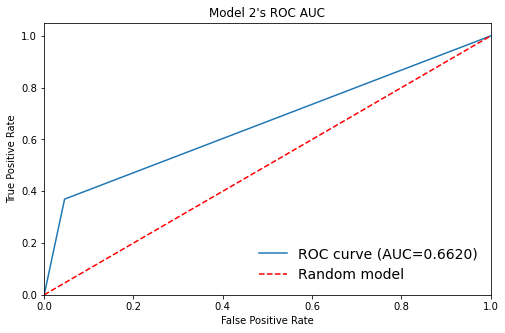

scoring=['roc_auc', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


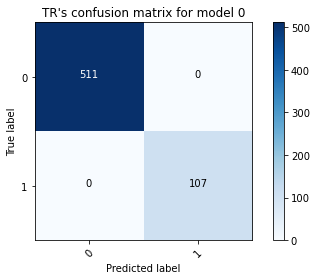

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


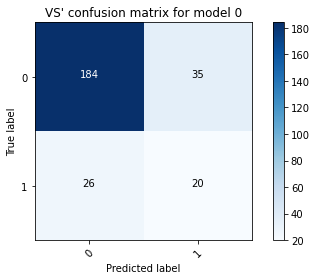

Parameters model 0 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


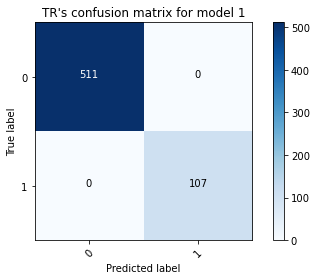

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


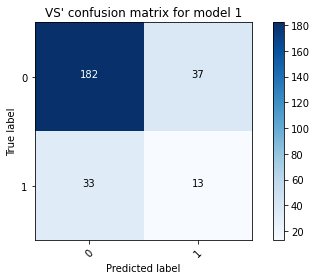

Parameters model 1 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


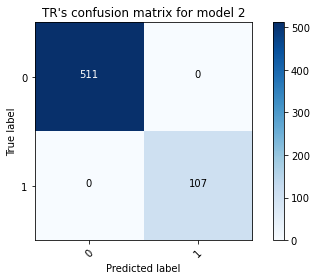

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


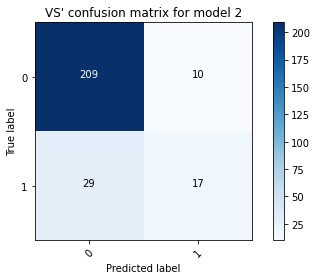

Parameters model 2 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


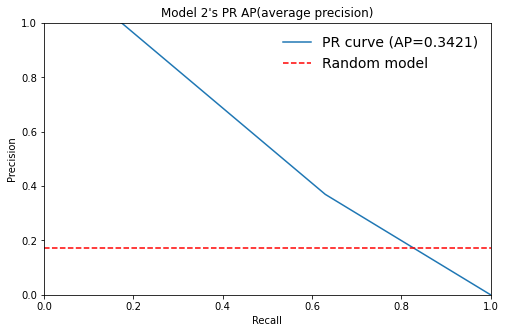

 Best Threshold=1.000000 


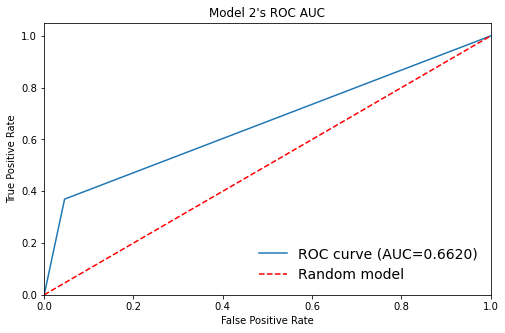

scoring=['f1', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   18.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   18.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


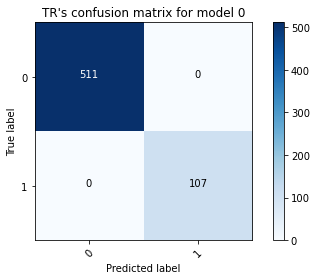

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


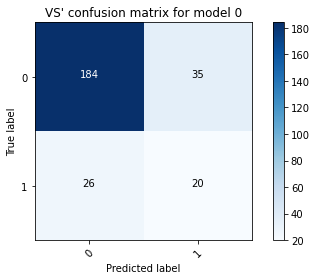

Parameters model 0 and resampling_label=scoring=['f1', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


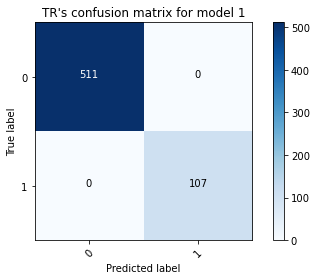

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


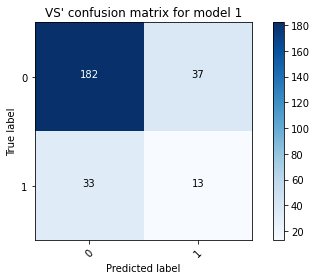

Parameters model 1 and resampling_label=scoring=['f1', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


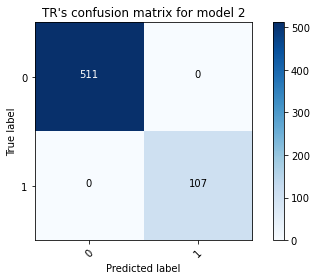

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


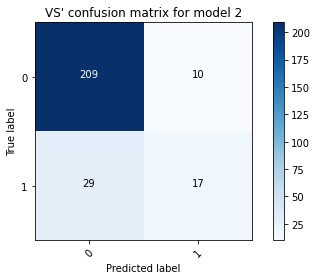

Parameters model 2 and resampling_label=scoring=['f1', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


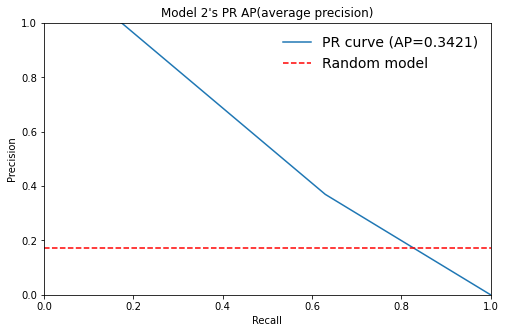

 Best Threshold=1.000000 


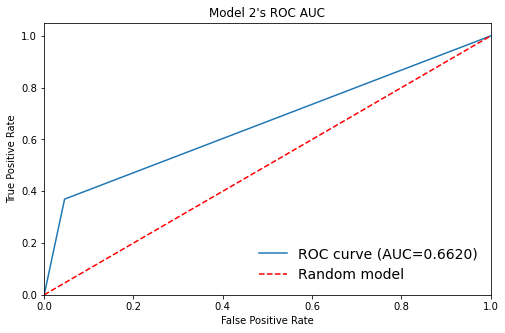

scoring=['f1', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


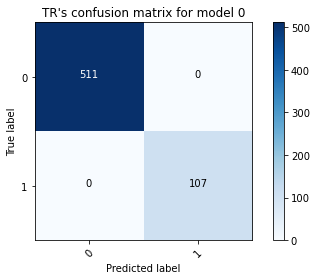

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


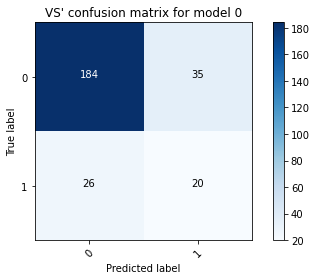

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


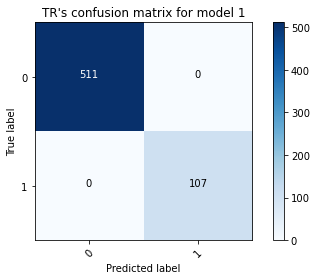

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


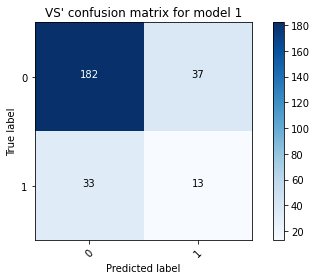

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


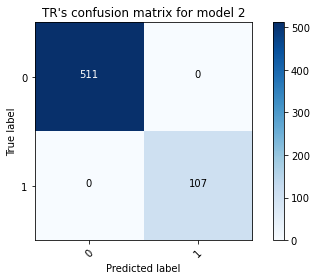

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


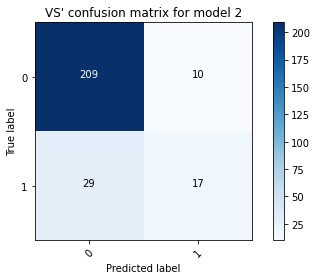

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


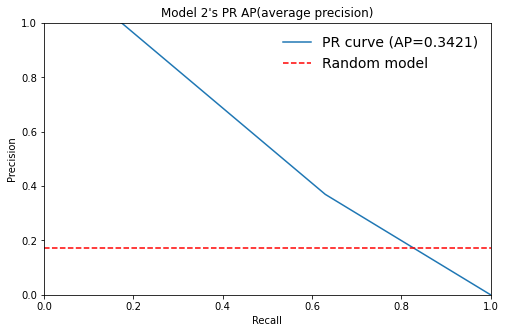

 Best Threshold=1.000000 


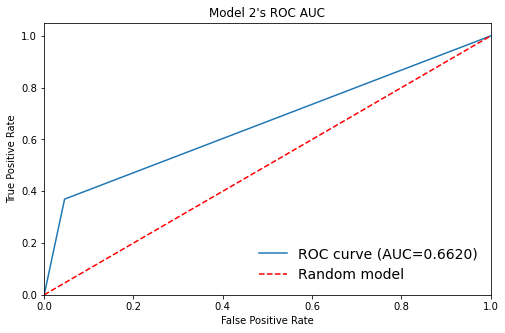

scoring=['f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


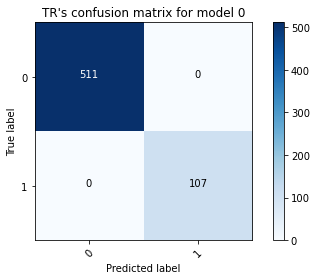

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


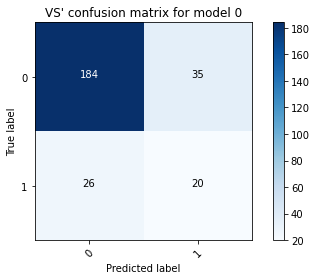

Parameters model 0 and resampling_label=scoring=['f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


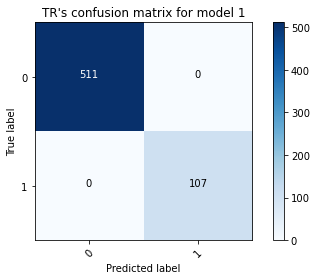

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


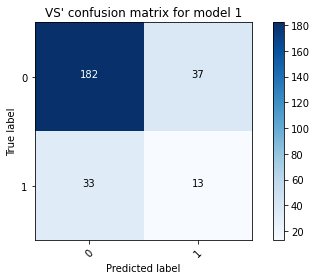

Parameters model 1 and resampling_label=scoring=['f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


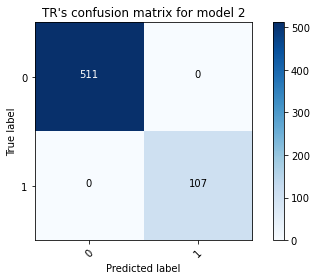

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


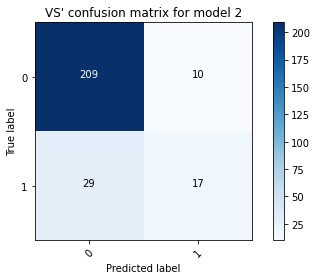

Parameters model 2 and resampling_label=scoring=['f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


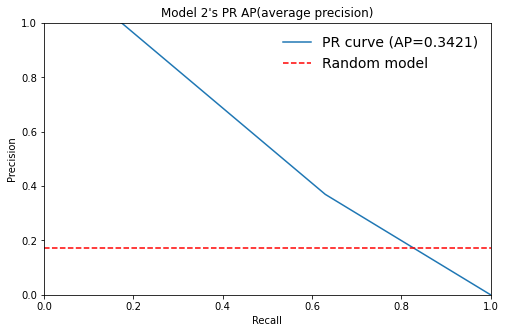

 Best Threshold=1.000000 


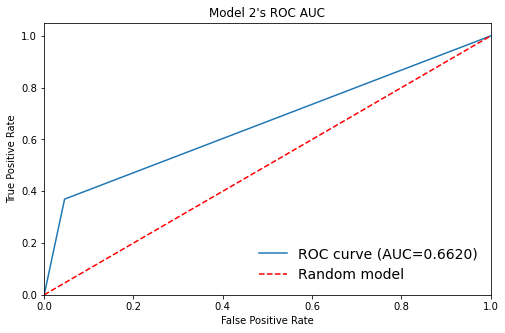

scoring=['f1', 'roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


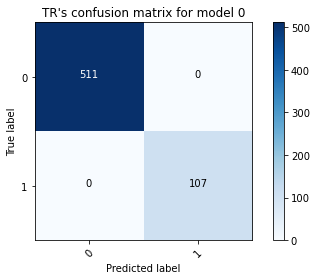

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


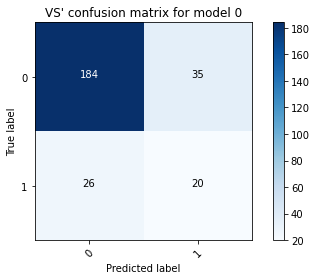

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


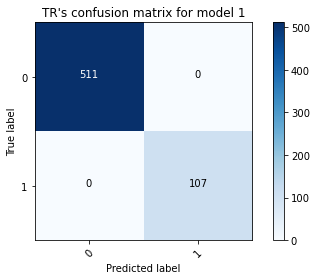

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


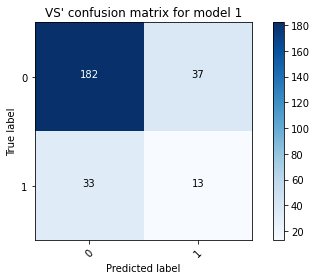

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


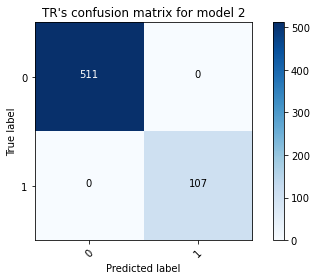

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


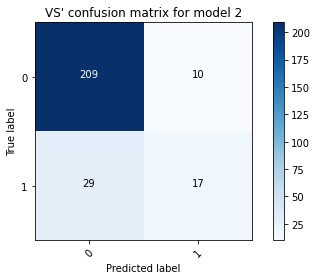

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


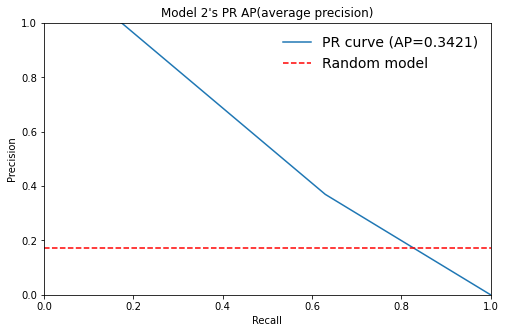

 Best Threshold=1.000000 


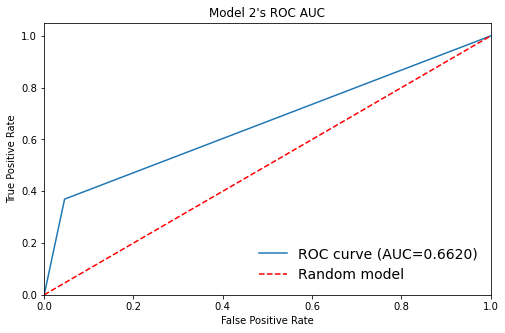

scoring=['f1', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


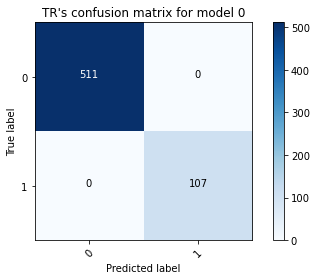

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


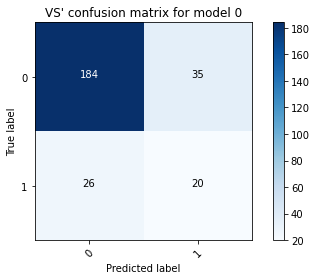

Parameters model 0 and resampling_label=scoring=['f1', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


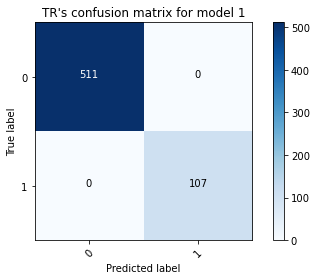

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


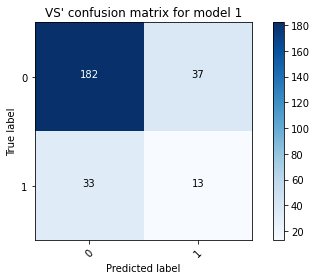

Parameters model 1 and resampling_label=scoring=['f1', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


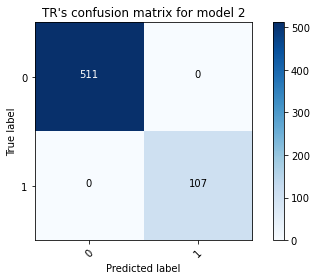

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


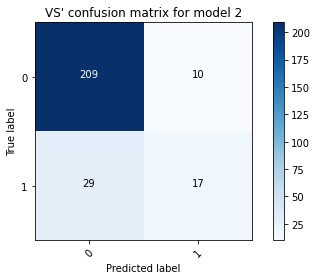

Parameters model 2 and resampling_label=scoring=['f1', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


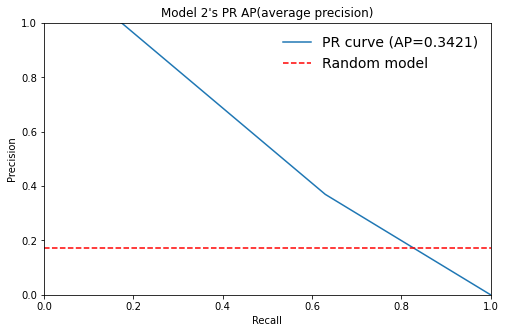

 Best Threshold=1.000000 


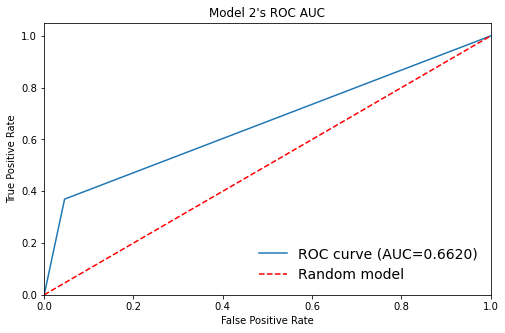

scoring=['f1', 'roc_auc', 'precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   21.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


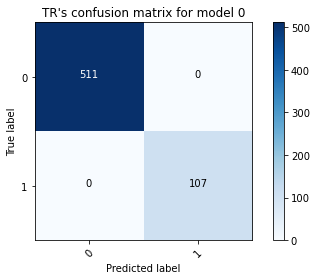

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


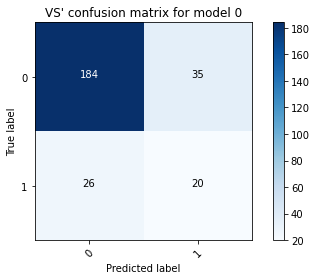

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


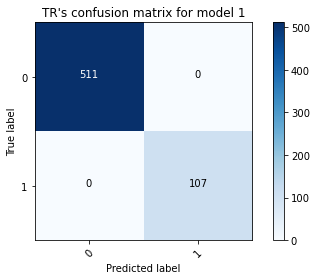

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


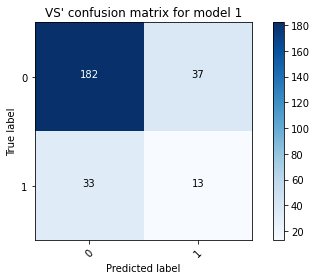

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


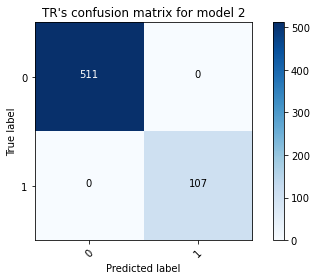

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


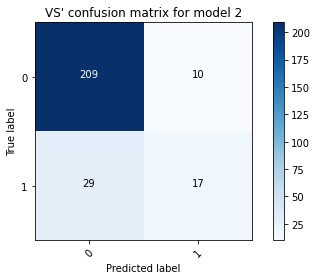

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


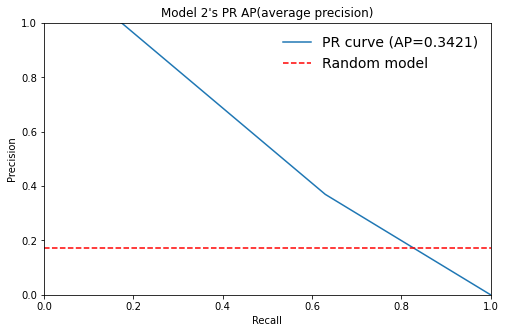

 Best Threshold=1.000000 


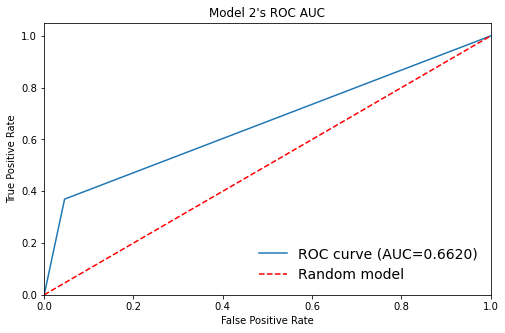

scoring=['roc_auc', 'precision', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   20.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   20.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


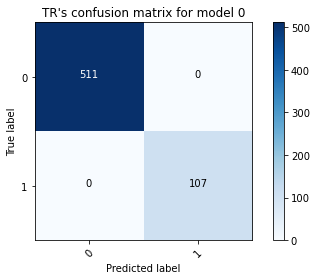

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


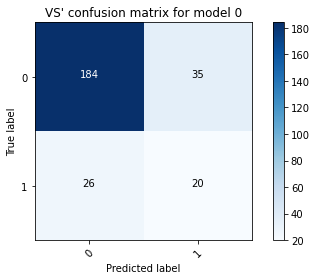

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


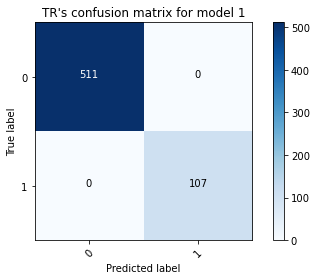

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


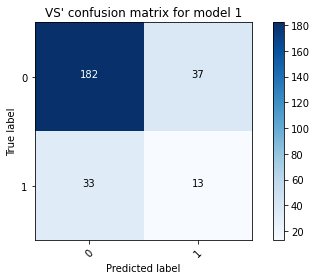

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


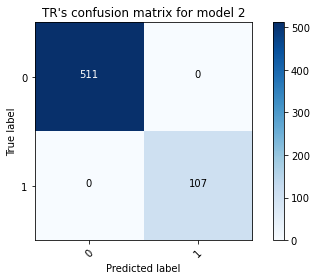

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


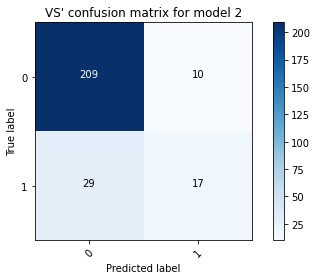

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


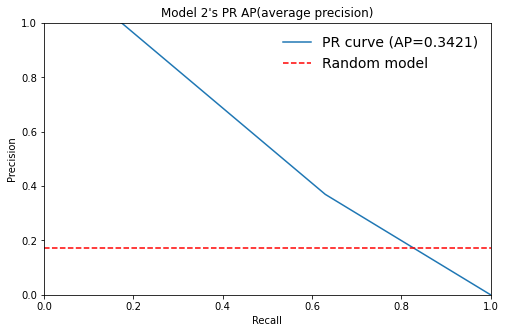

 Best Threshold=1.000000 


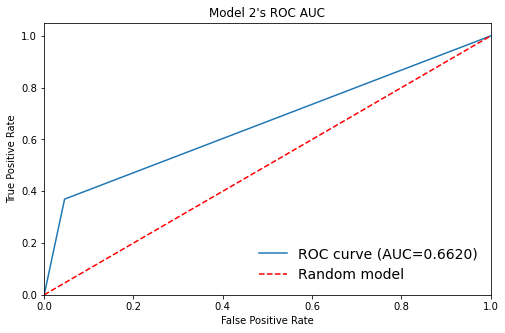

scoring=['roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   20.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


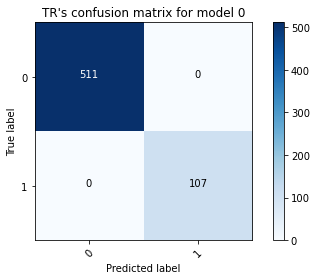

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


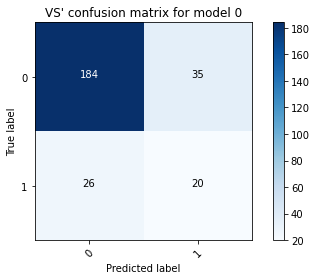

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


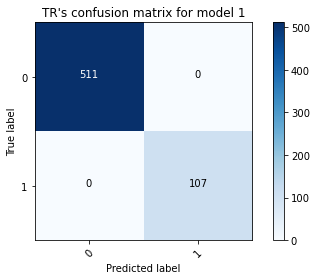

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


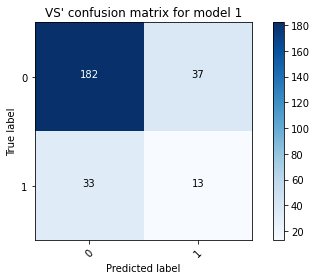

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


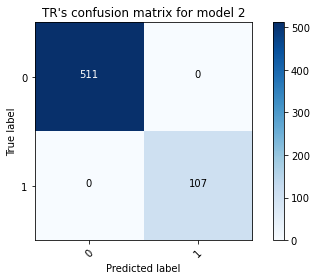

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


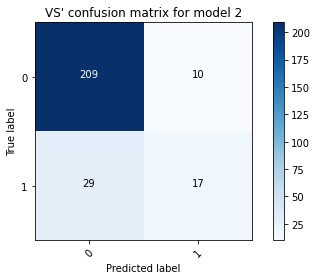

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


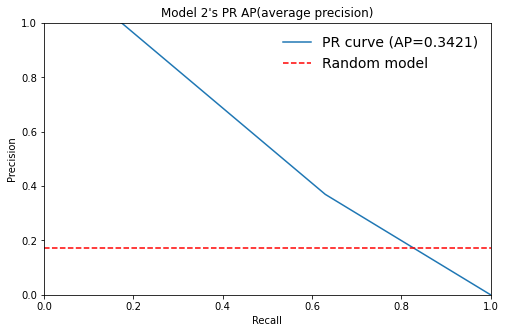

 Best Threshold=1.000000 


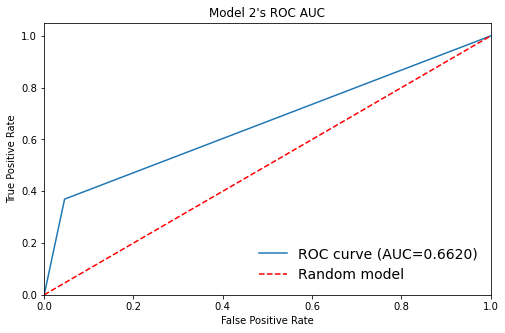

scoring=['roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   21.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


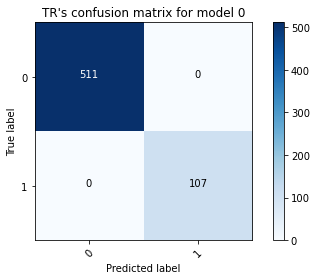

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


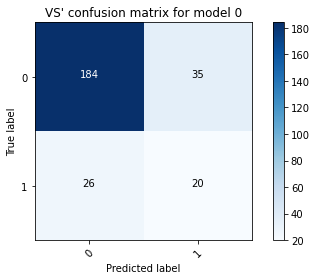

Parameters model 0 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


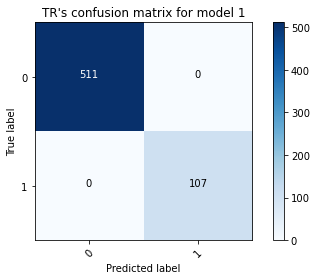

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


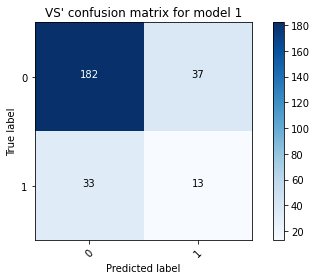

Parameters model 1 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


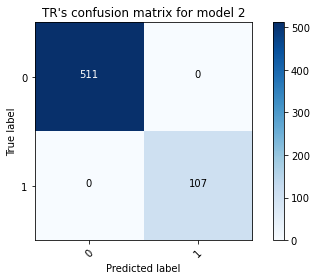

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


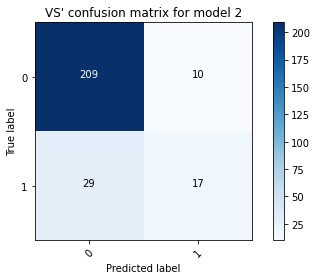

Parameters model 2 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


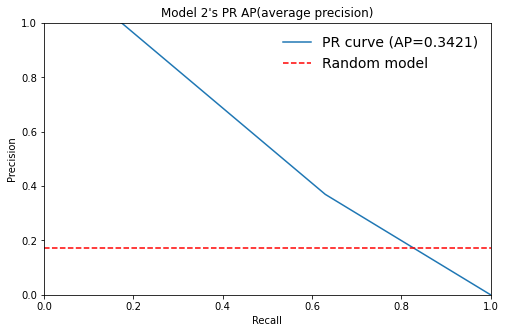

 Best Threshold=1.000000 


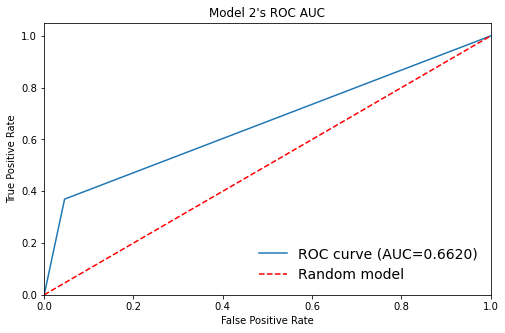

scoring=['f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


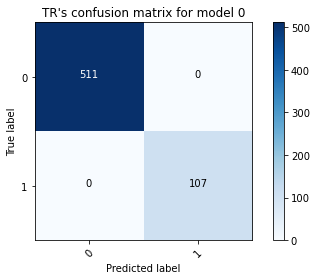

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


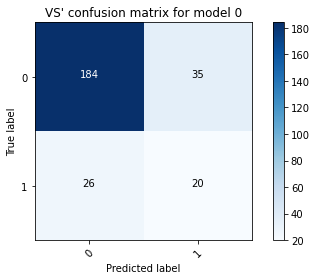

Parameters model 0 and resampling_label=scoring=['f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


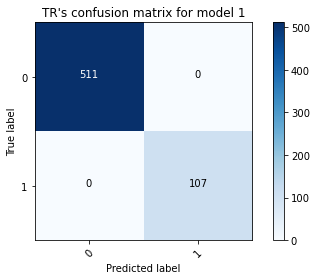

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


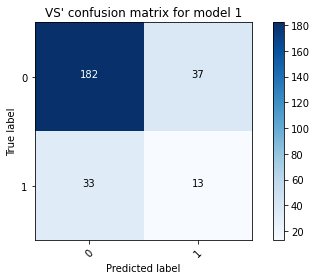

Parameters model 1 and resampling_label=scoring=['f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


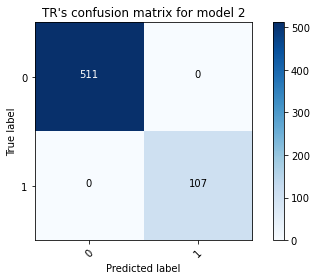

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


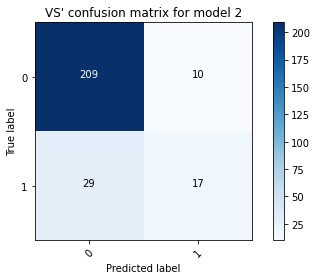

Parameters model 2 and resampling_label=scoring=['f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


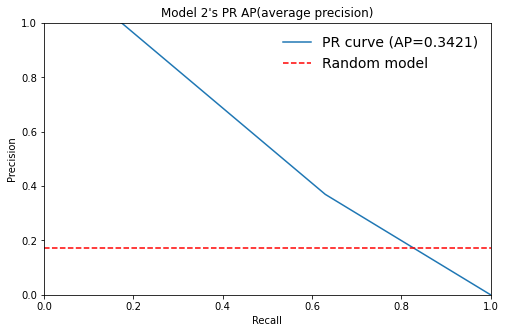

 Best Threshold=1.000000 


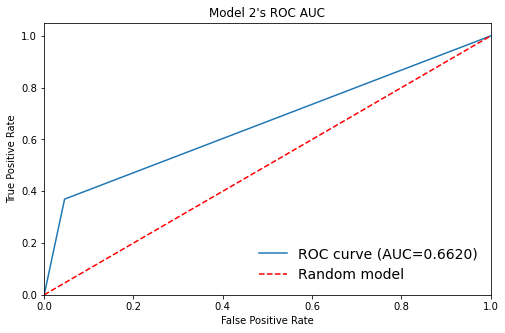

scoring=['f1', 'precision', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   18.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   18.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


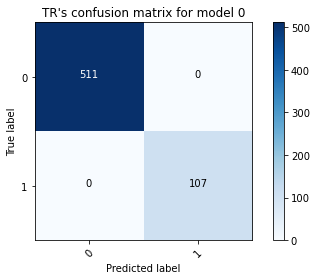

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


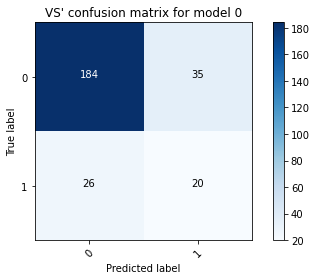

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


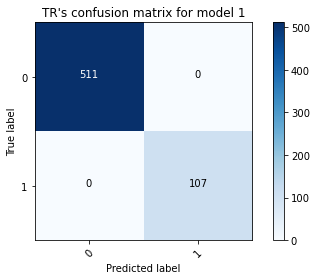

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


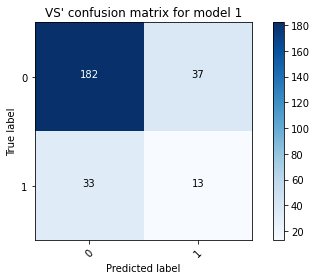

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


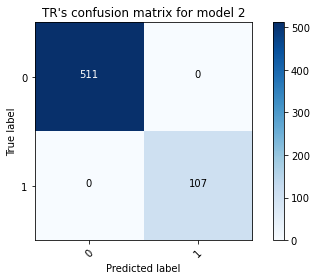

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


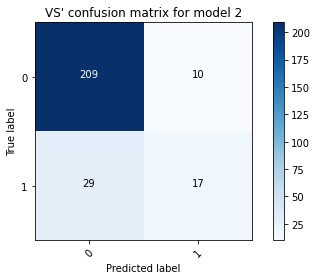

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


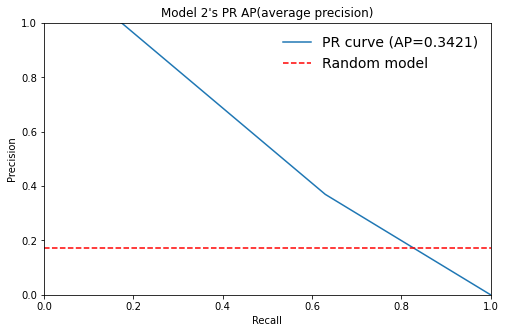

 Best Threshold=1.000000 


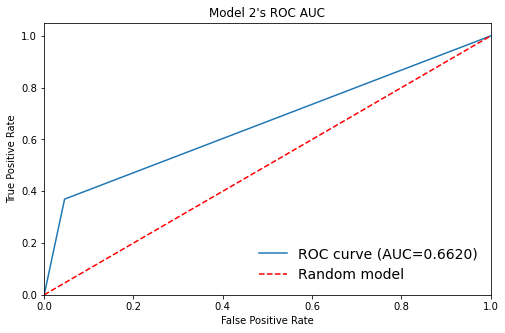

scoring=['roc_auc', 'precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   17.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   18.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


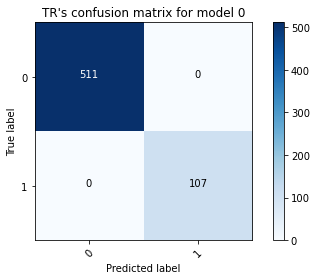

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


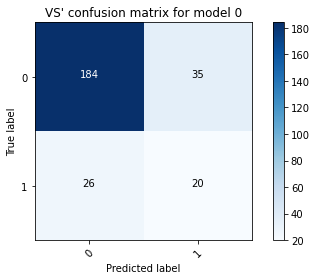

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


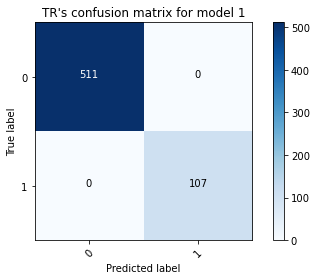

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


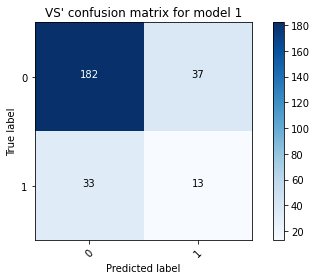

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


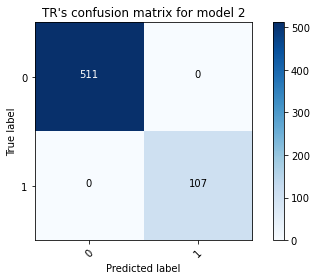

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


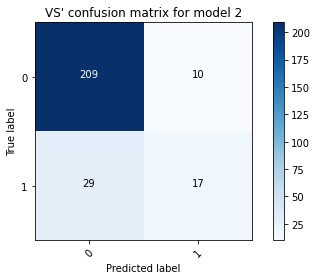

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


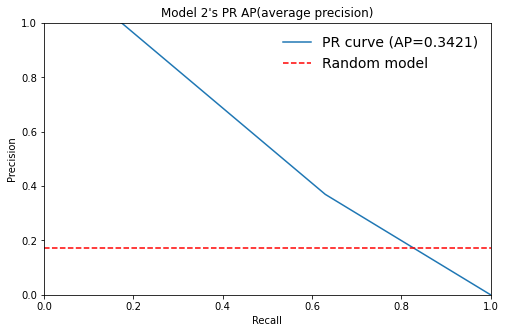

 Best Threshold=1.000000 


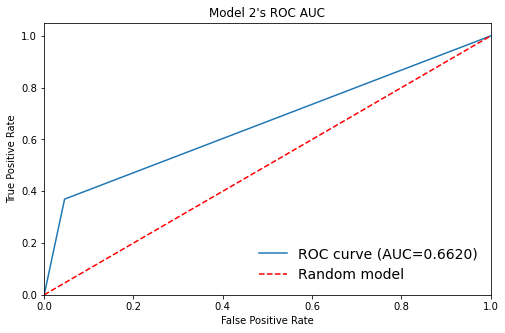

scoring=['roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   21.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


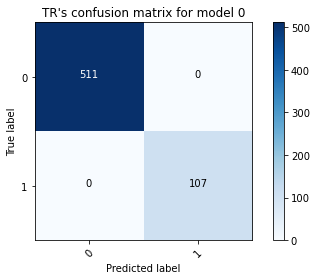

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


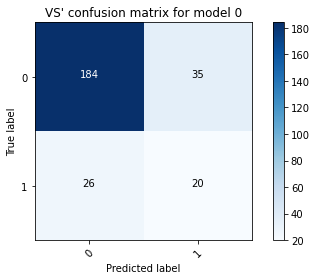

Parameters model 0 and resampling_label=scoring=['roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


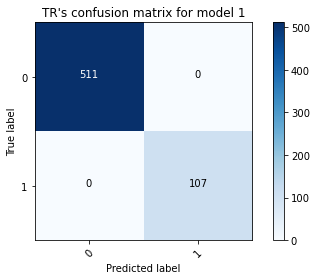

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


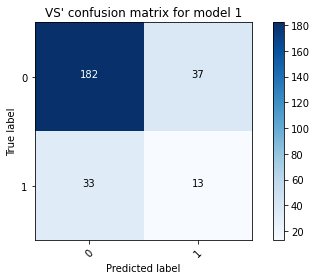

Parameters model 1 and resampling_label=scoring=['roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


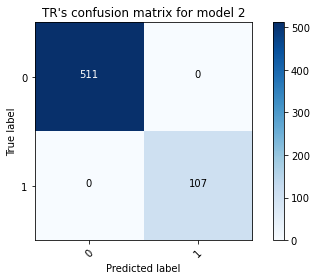

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


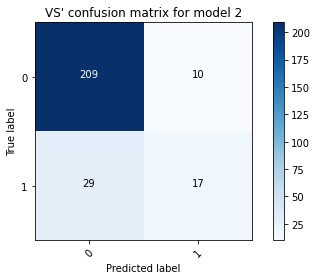

Parameters model 2 and resampling_label=scoring=['roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


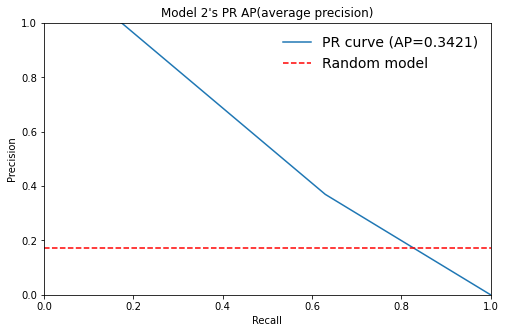

 Best Threshold=1.000000 


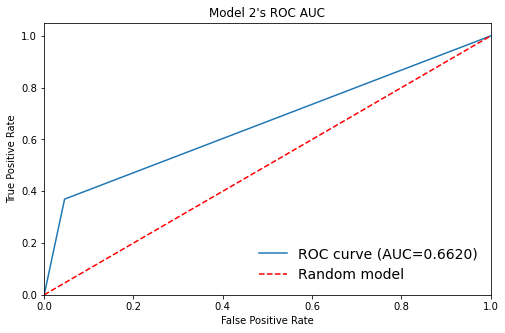

scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   24.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   24.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


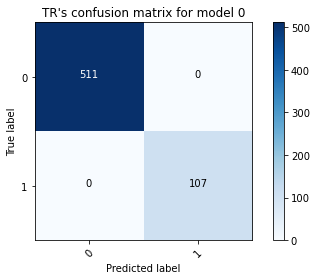

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


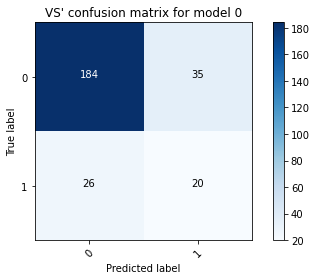

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


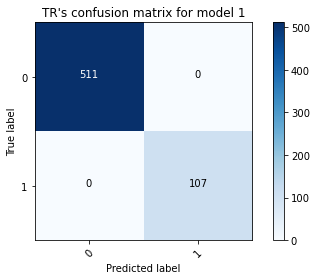

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


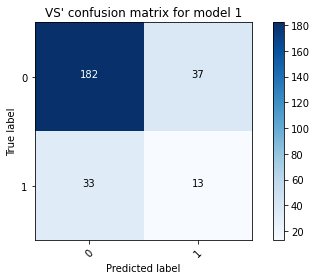

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


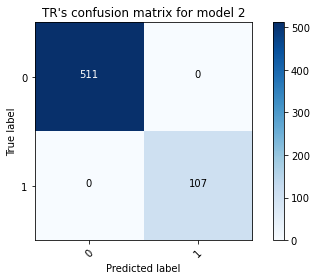

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


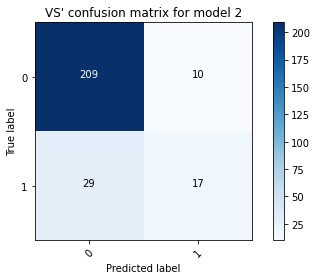

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


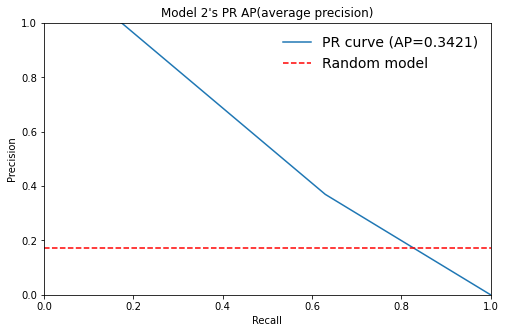

 Best Threshold=1.000000 


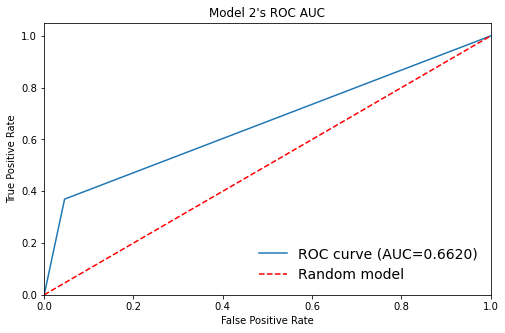

scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   25.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.1s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


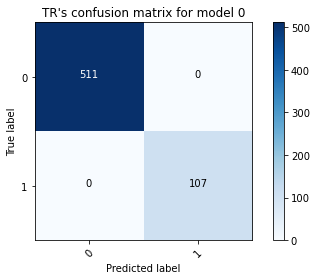

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


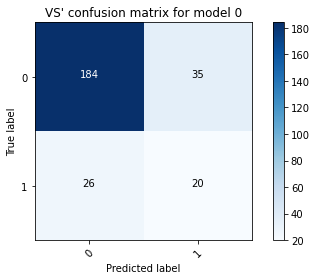

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


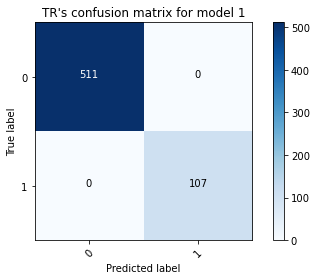

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


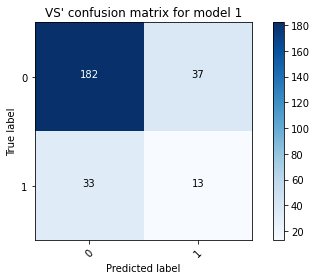

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


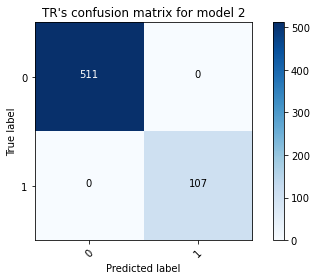

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


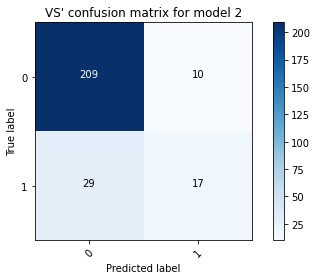

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


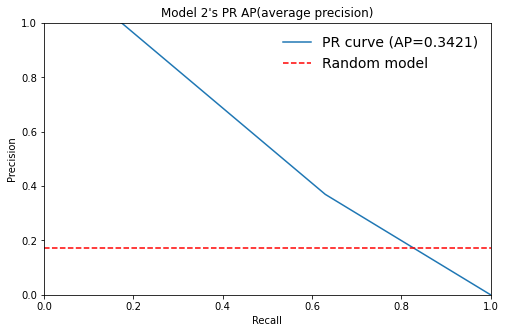

 Best Threshold=1.000000 


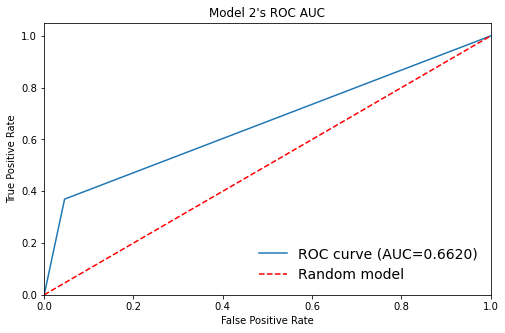

scoring=['f1', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


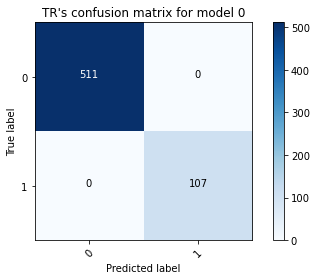

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


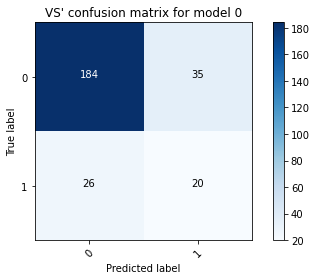

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


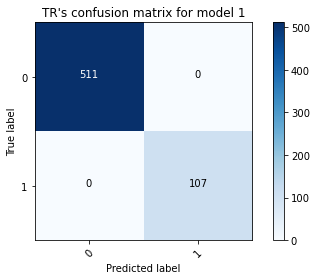

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


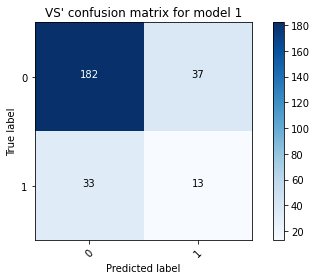

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


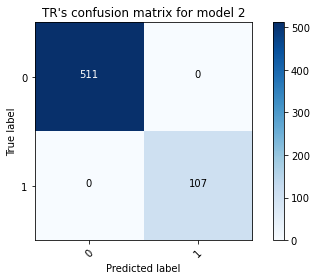

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


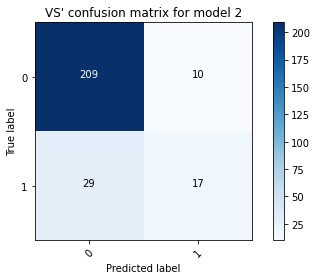

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


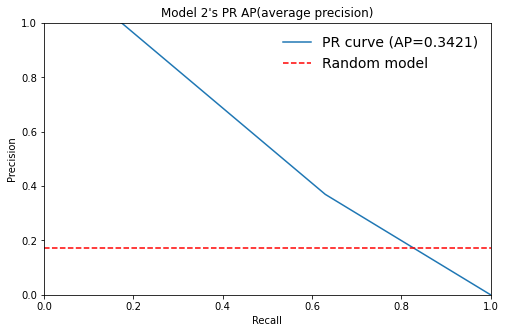

 Best Threshold=1.000000 


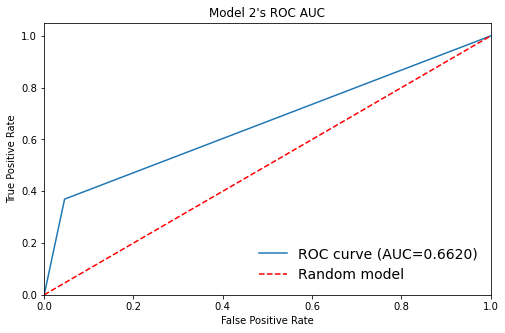

scoring=['roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   22.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


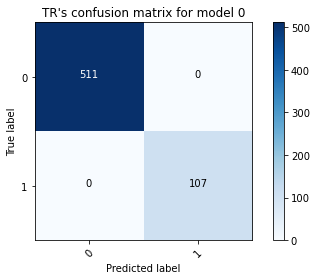

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


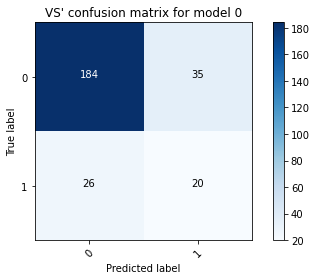

Parameters model 0 and resampling_label=scoring=['roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


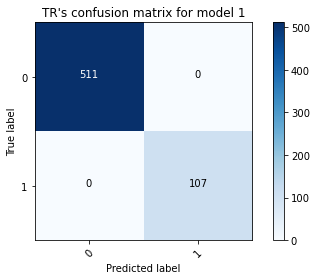

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


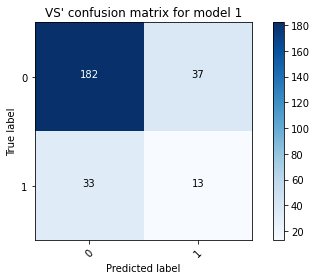

Parameters model 1 and resampling_label=scoring=['roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


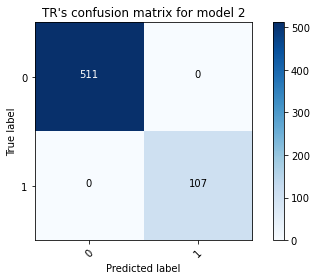

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


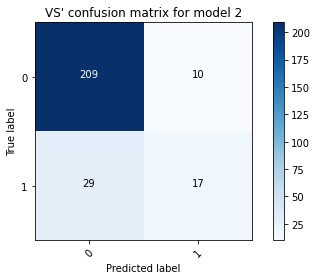

Parameters model 2 and resampling_label=scoring=['roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


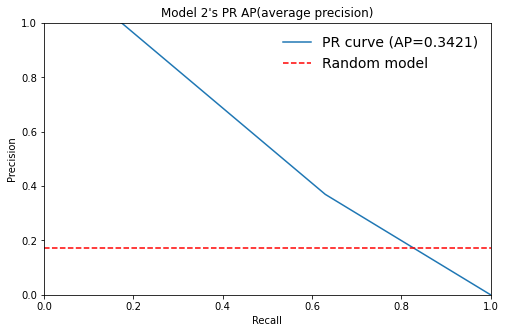

 Best Threshold=1.000000 


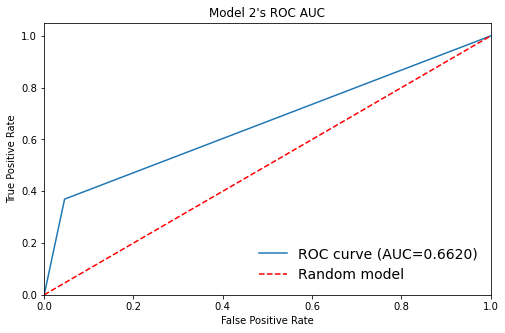

scoring=['roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   27.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   27.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


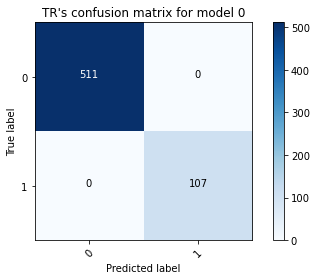

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


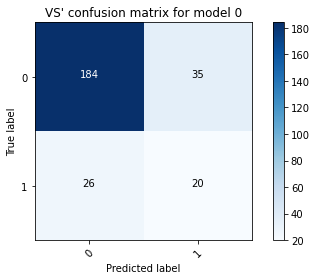

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


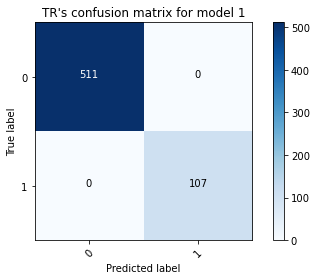

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


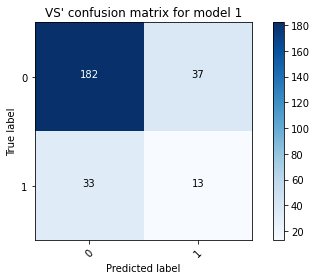

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


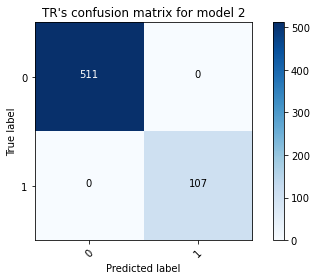

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


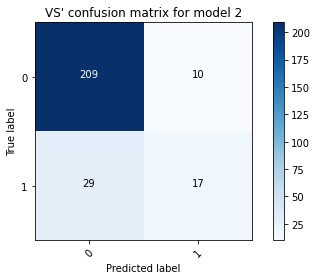

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


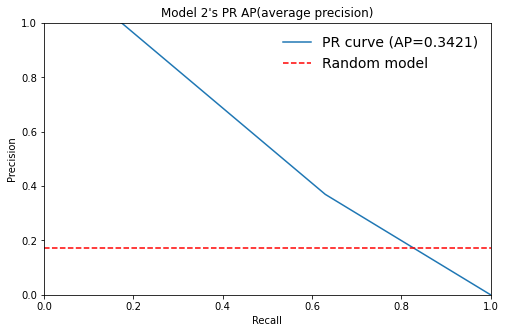

 Best Threshold=1.000000 


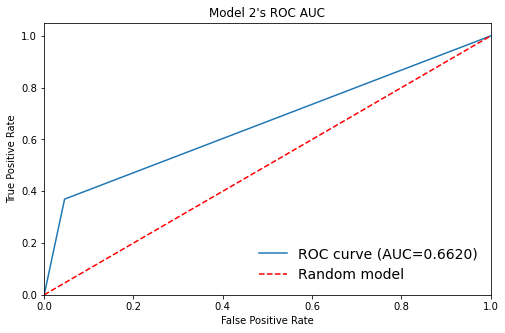

scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


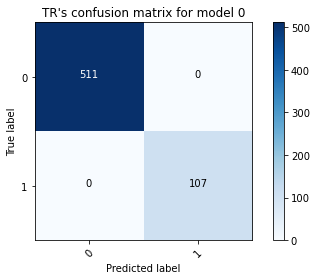

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


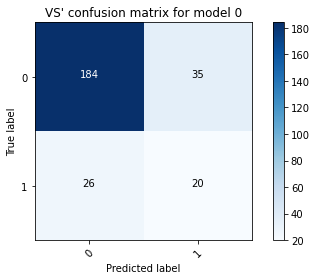

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


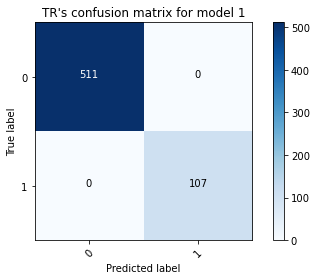

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


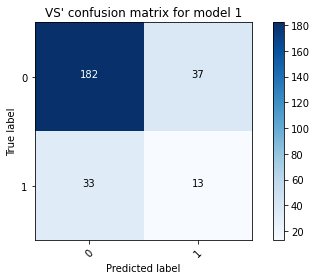

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


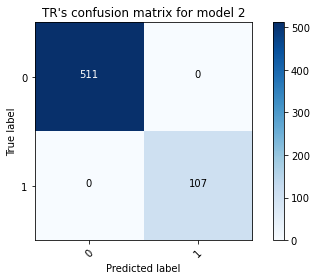

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


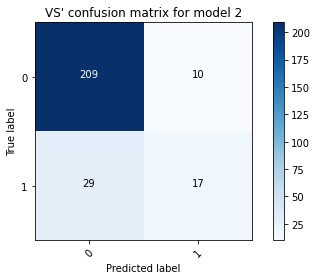

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


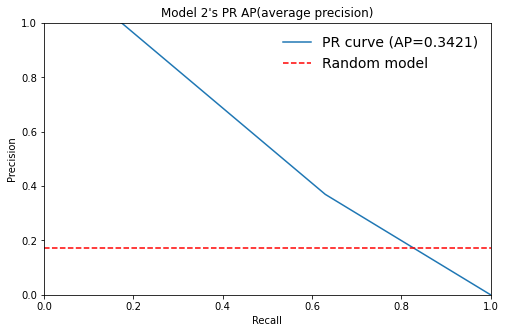

 Best Threshold=1.000000 


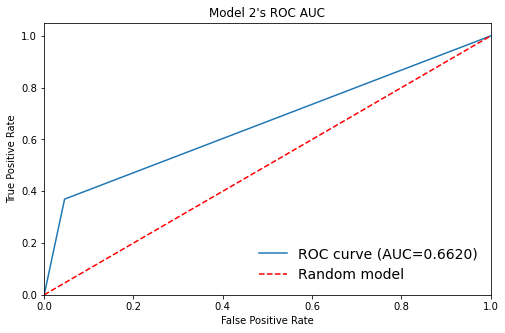

scoring=['roc_auc', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   24.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.1s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


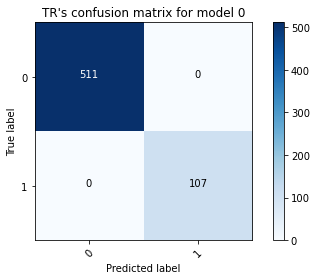

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


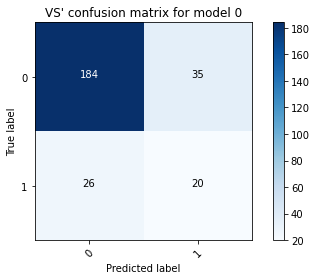

Parameters model 0 and resampling_label=scoring=['roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


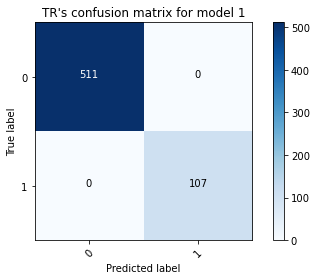

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


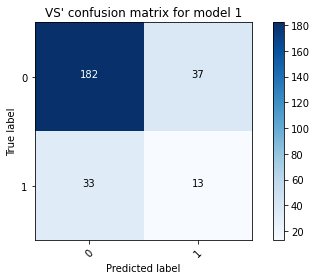

Parameters model 1 and resampling_label=scoring=['roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


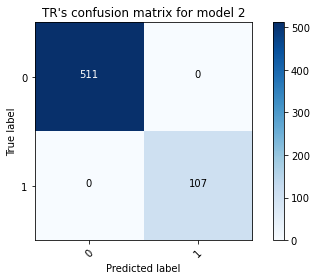

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


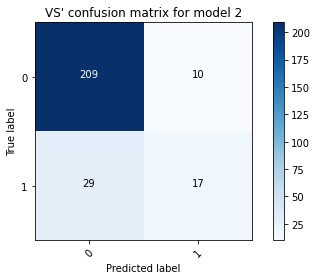

Parameters model 2 and resampling_label=scoring=['roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


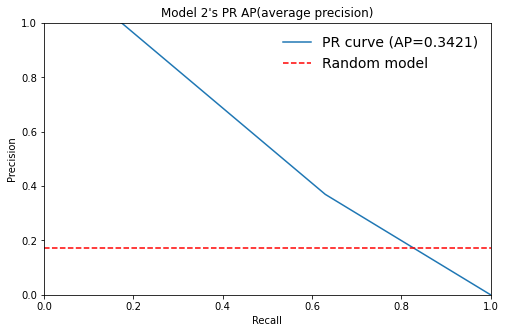

 Best Threshold=1.000000 


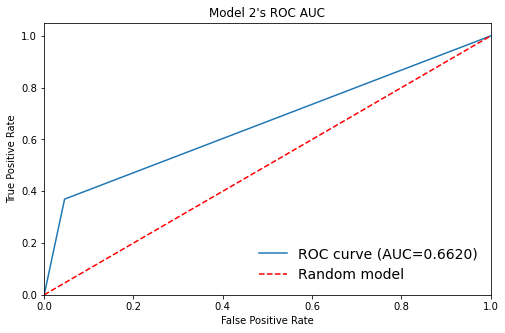

scoring=['f1', 'roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


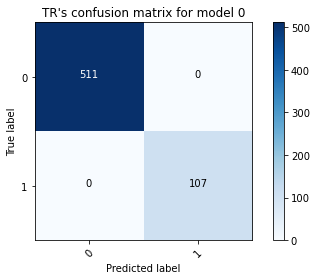

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


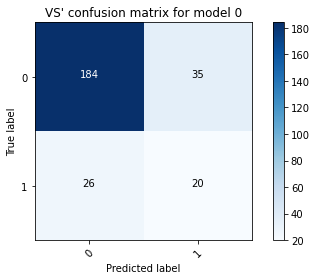

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


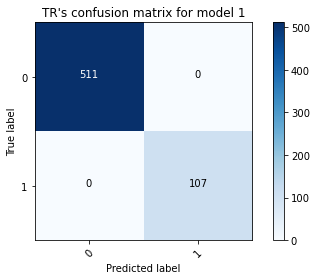

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


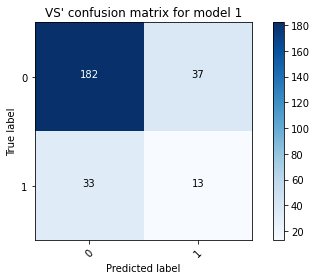

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


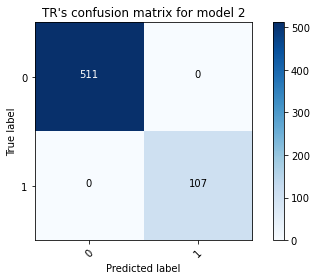

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


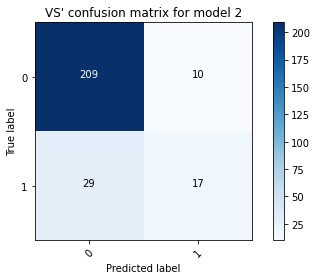

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


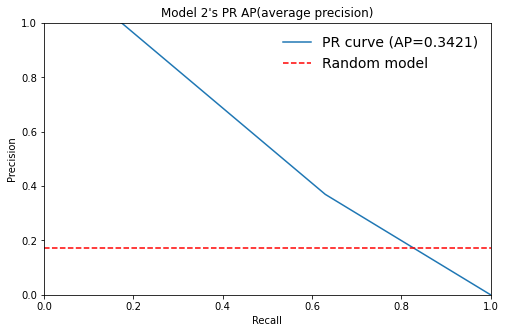

 Best Threshold=1.000000 


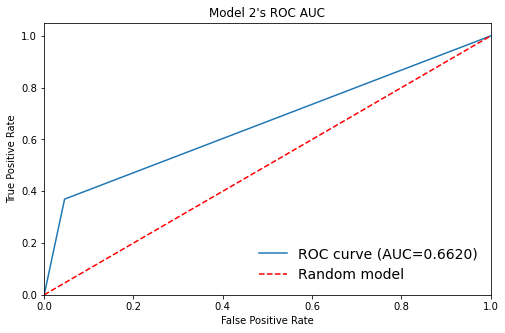

scoring=['f1', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   22.6s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


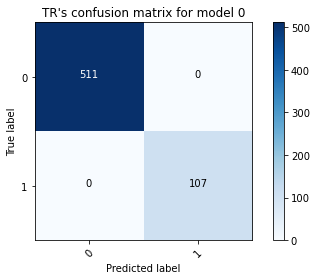

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


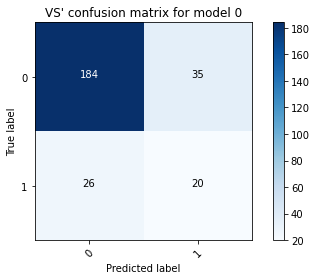

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


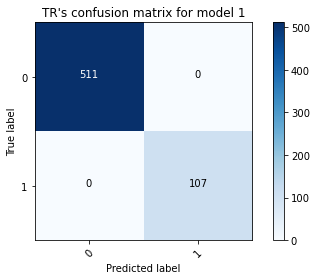

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


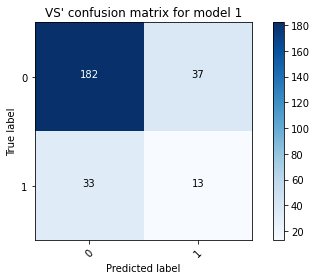

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


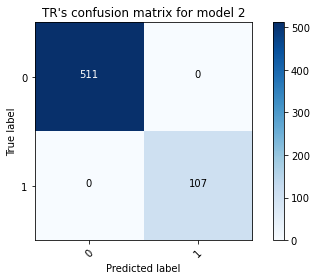

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


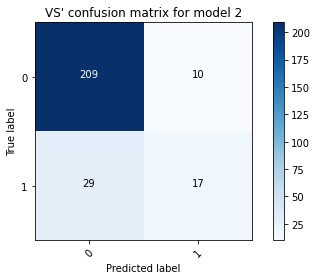

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


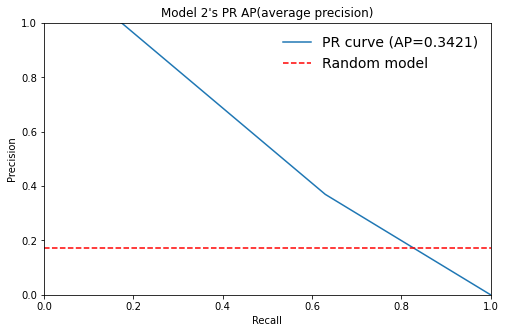

 Best Threshold=1.000000 


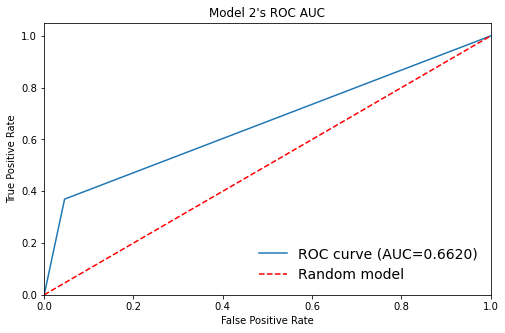

scoring=['f1', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


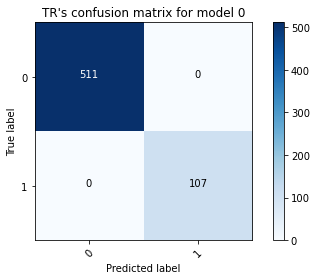

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


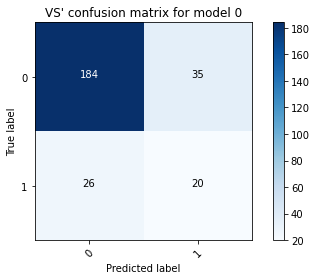

Parameters model 0 and resampling_label=scoring=['f1', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


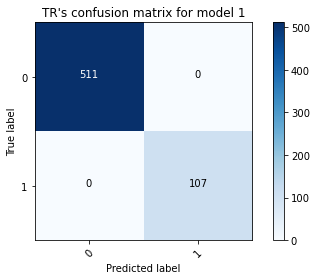

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


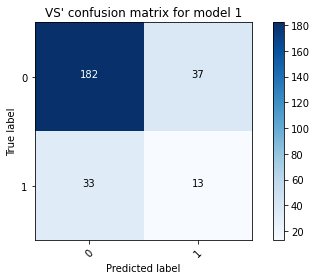

Parameters model 1 and resampling_label=scoring=['f1', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


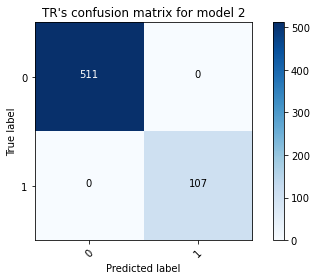

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


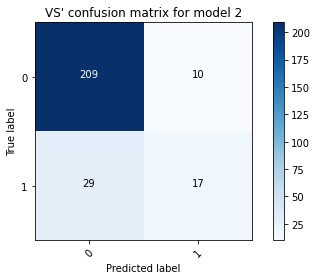

Parameters model 2 and resampling_label=scoring=['f1', 'precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


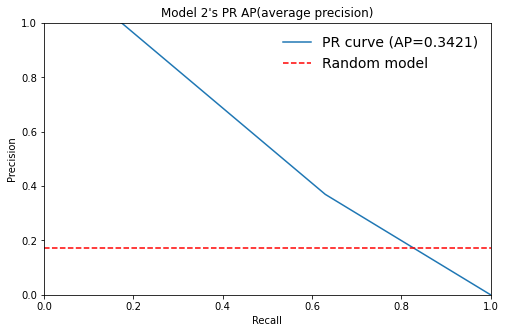

 Best Threshold=1.000000 


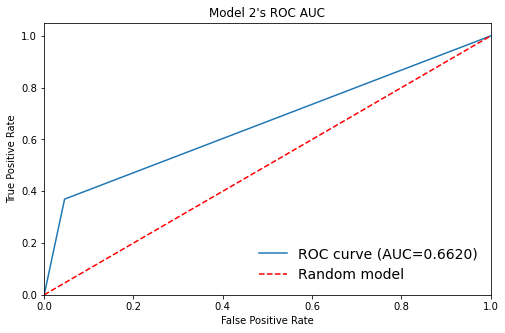

scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


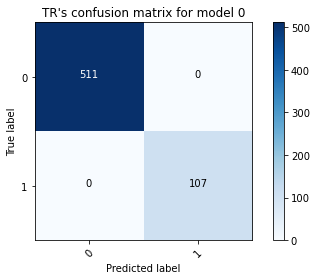

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


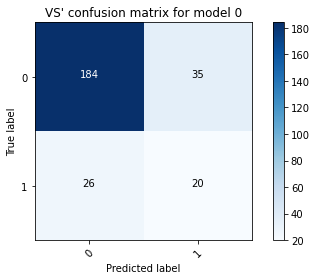

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


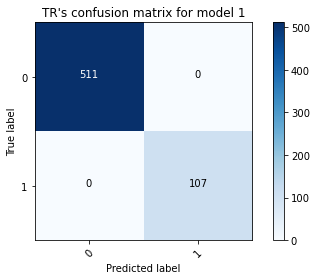

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


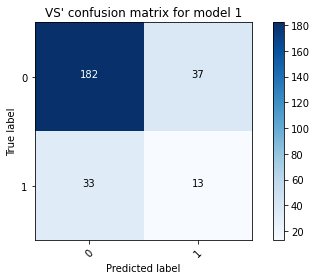

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


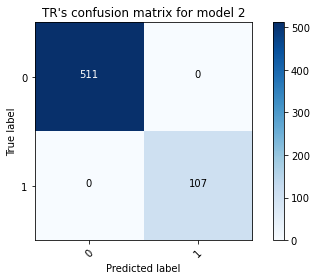

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


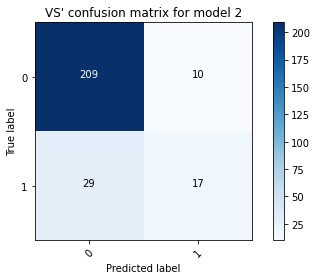

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


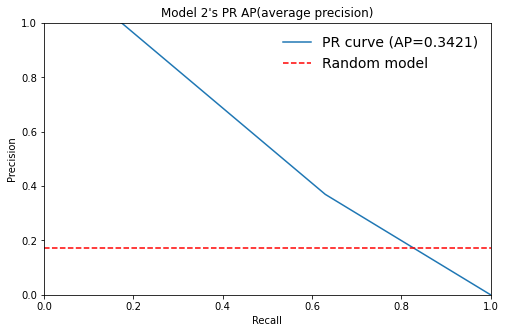

 Best Threshold=1.000000 


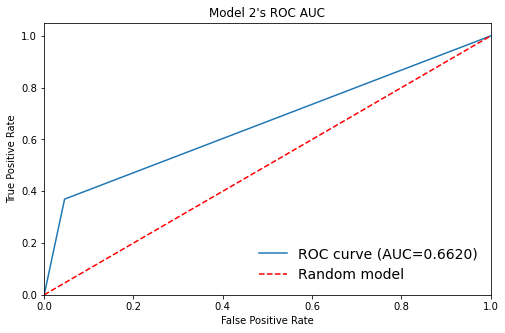

scoring=['f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   12.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


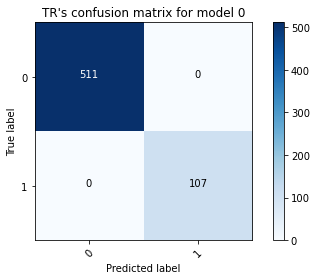

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


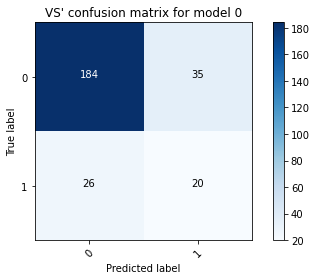

Parameters model 0 and resampling_label=scoring=['f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


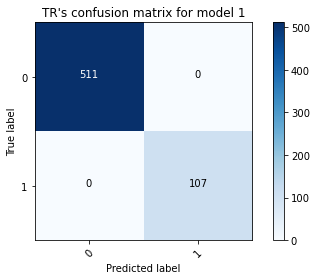

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


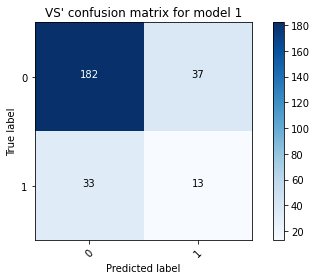

Parameters model 1 and resampling_label=scoring=['f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


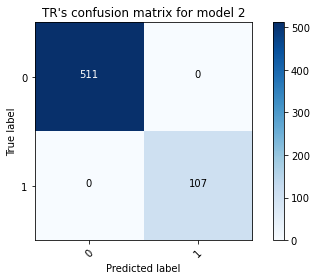

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


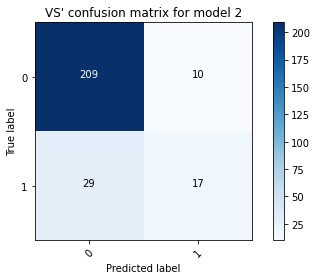

Parameters model 2 and resampling_label=scoring=['f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


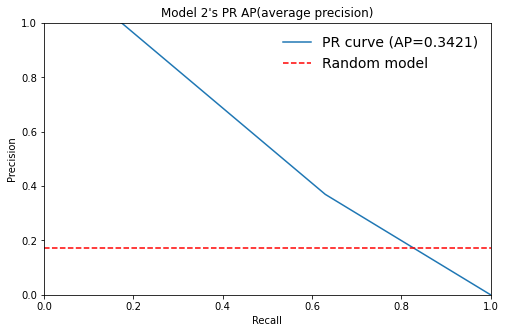

 Best Threshold=1.000000 


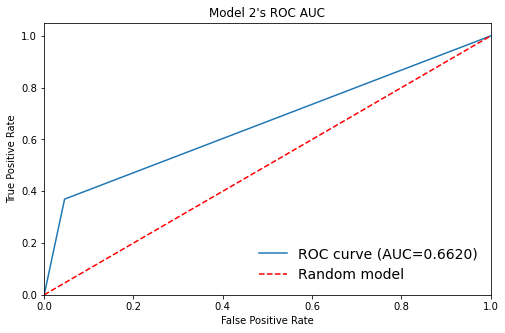

scoring=['precision', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


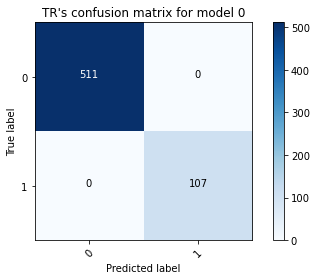

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


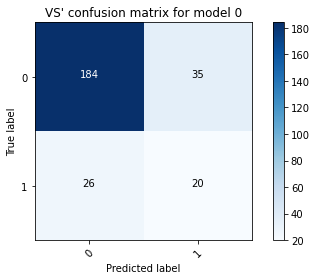

Parameters model 0 and resampling_label=scoring=['precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


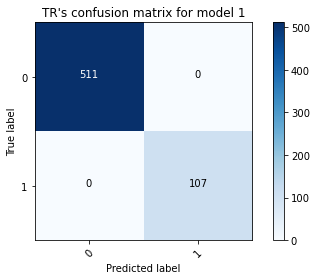

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


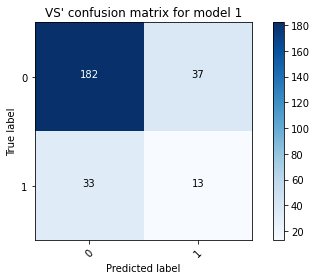

Parameters model 1 and resampling_label=scoring=['precision', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


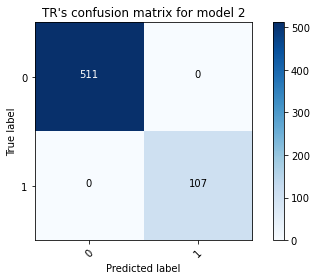

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


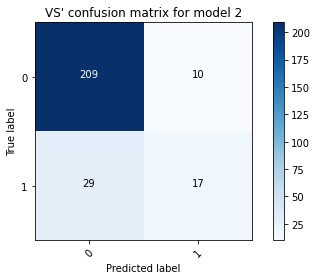

Parameters model 2 and resampling_label=scoring=['precision', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


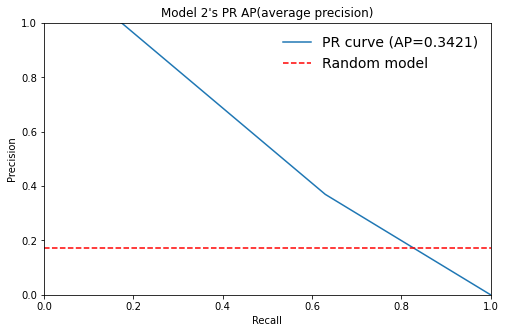

 Best Threshold=1.000000 


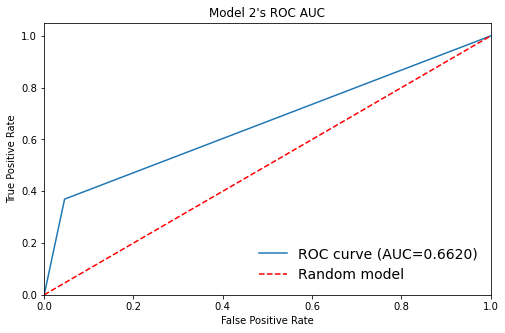

scoring=['f1', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   23.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.9s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


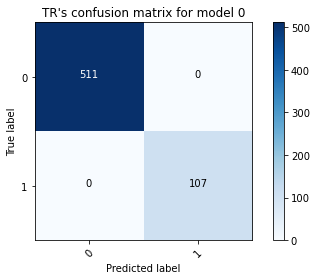

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


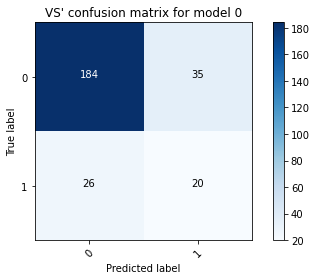

Parameters model 0 and resampling_label=scoring=['f1', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


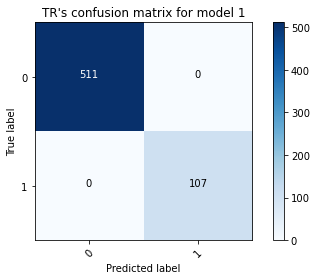

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


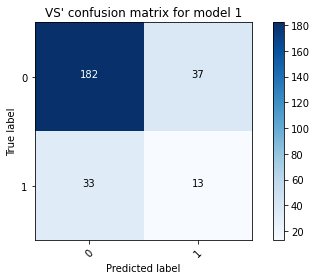

Parameters model 1 and resampling_label=scoring=['f1', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


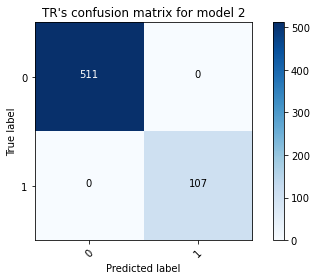

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


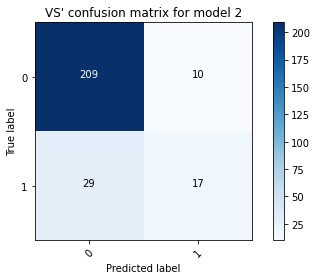

Parameters model 2 and resampling_label=scoring=['f1', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


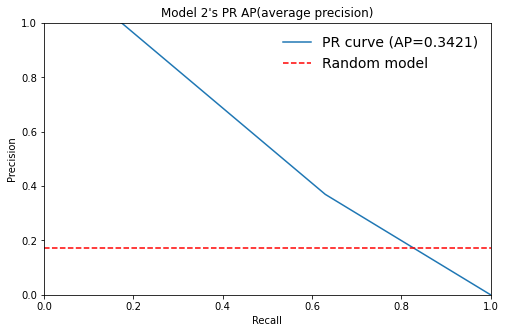

 Best Threshold=1.000000 


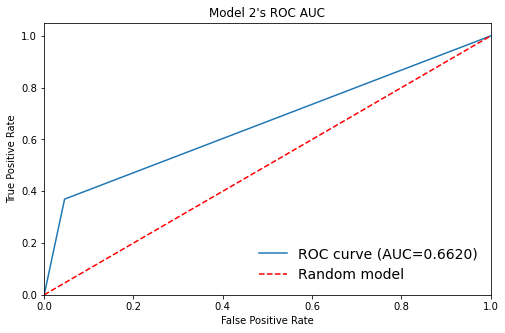

scoring=['precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   24.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


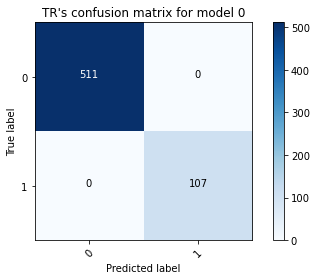

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


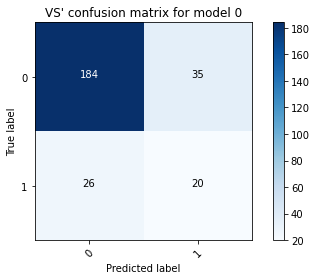

Parameters model 0 and resampling_label=scoring=['precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


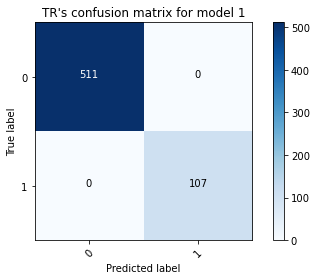

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


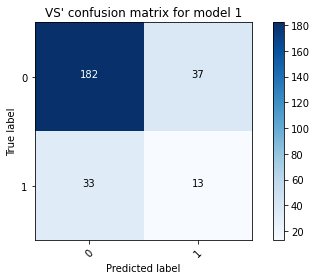

Parameters model 1 and resampling_label=scoring=['precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


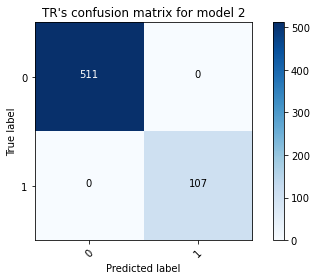

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


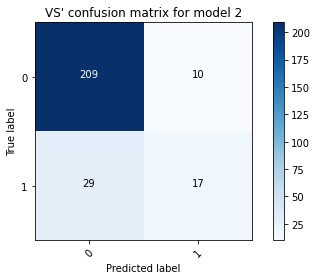

Parameters model 2 and resampling_label=scoring=['precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


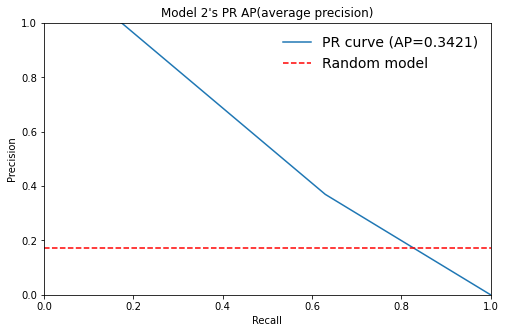

 Best Threshold=1.000000 


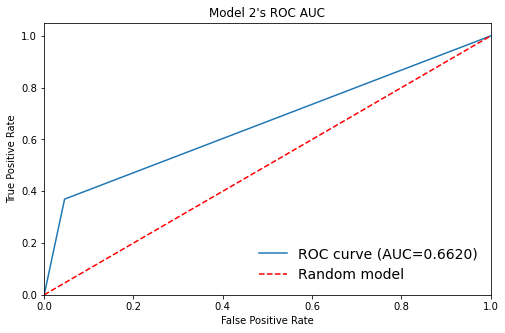

scoring=['roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   25.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.0s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


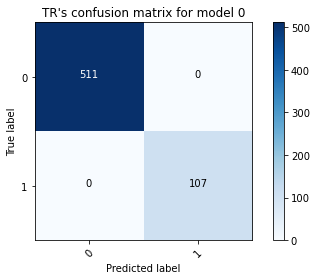

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


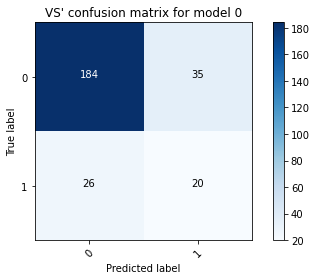

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


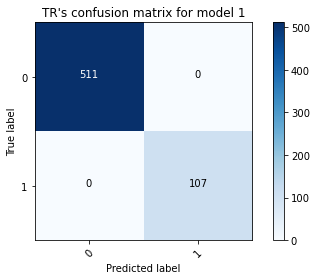

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


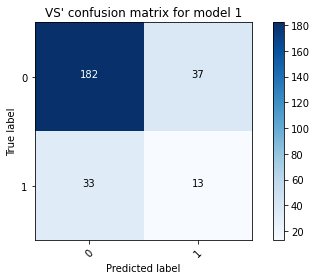

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


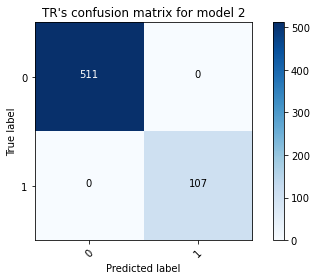

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


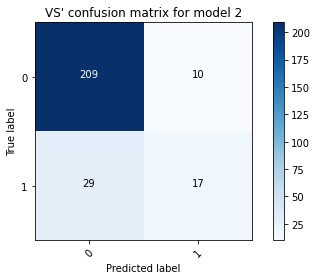

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


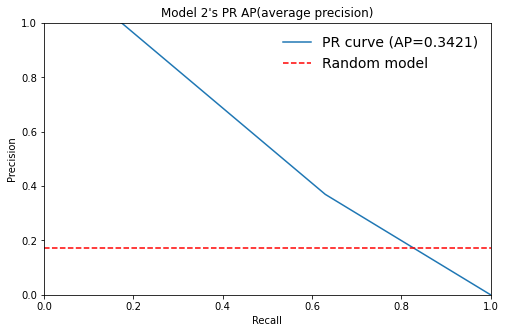

 Best Threshold=1.000000 


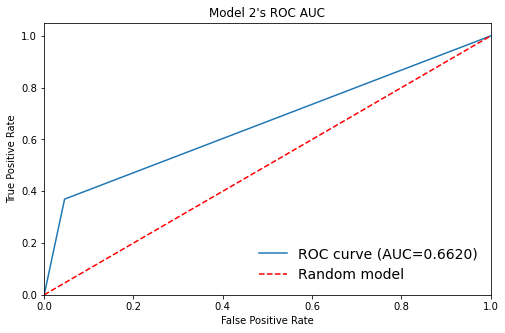

scoring=['precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


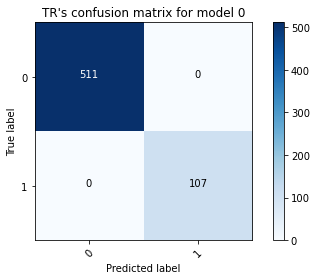

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


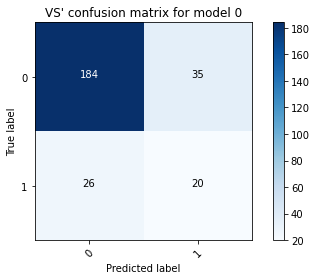

Parameters model 0 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


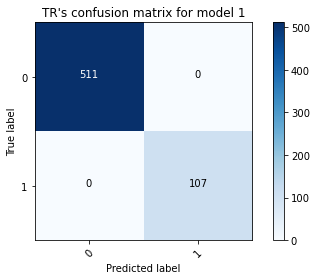

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


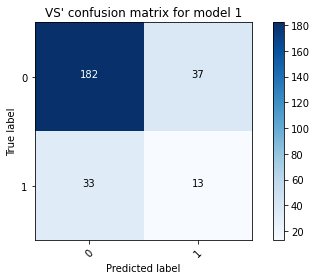

Parameters model 1 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


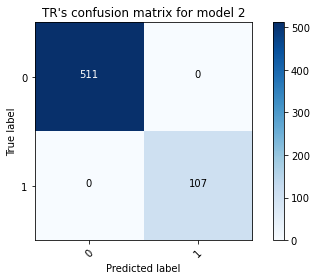

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


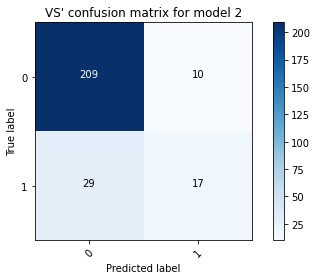

Parameters model 2 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


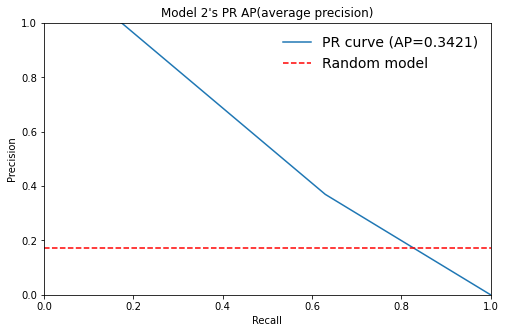

 Best Threshold=1.000000 


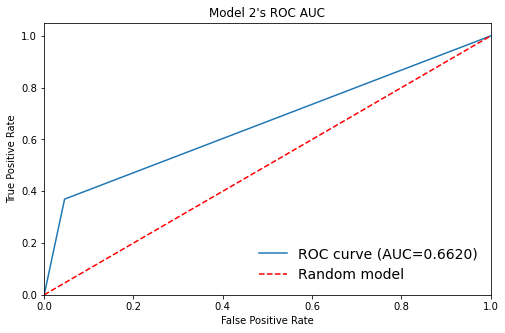

scoring=['f1', 'roc_auc', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.4s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


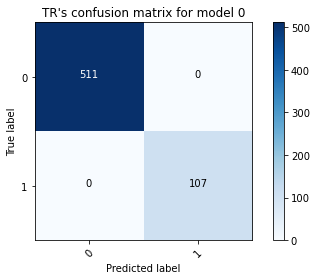

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


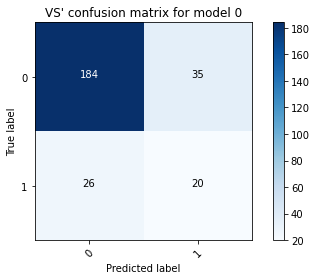

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


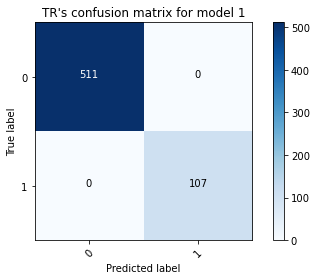

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


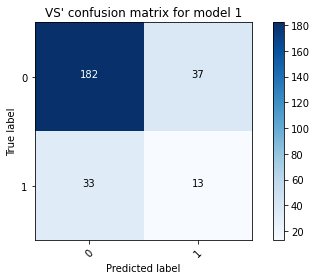

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


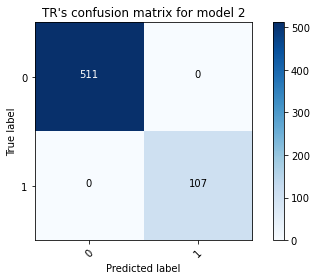

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


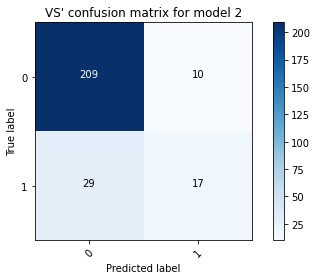

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


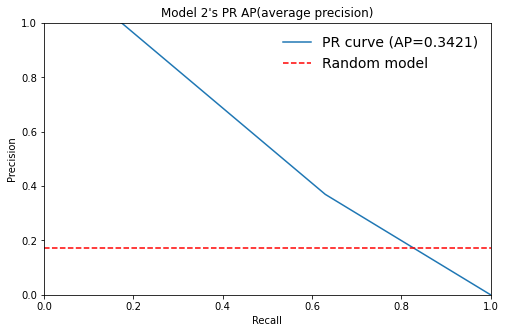

 Best Threshold=1.000000 


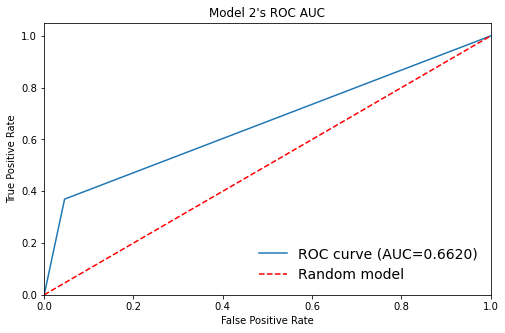

scoring=['precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   16.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   16.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


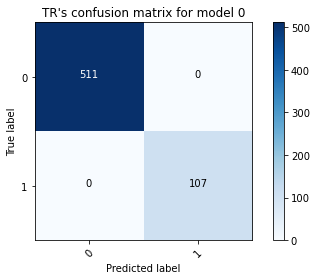

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


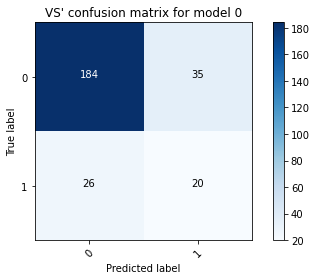

Parameters model 0 and resampling_label=scoring=['precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


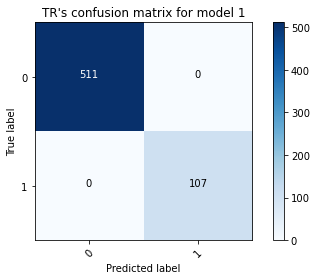

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


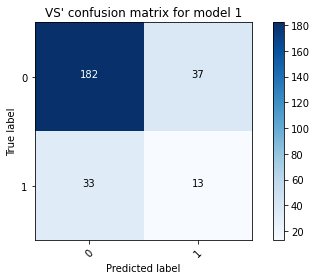

Parameters model 1 and resampling_label=scoring=['precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


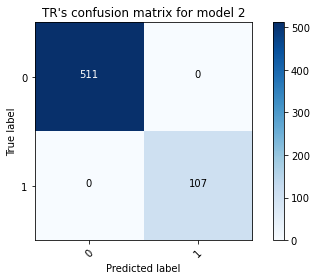

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


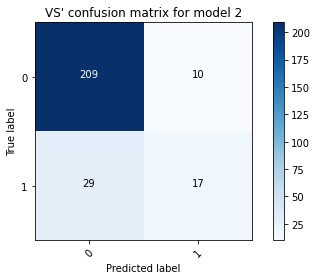

Parameters model 2 and resampling_label=scoring=['precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


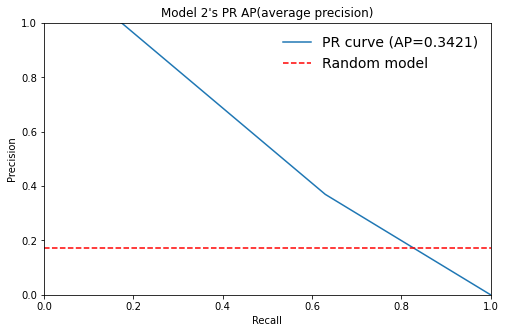

 Best Threshold=1.000000 


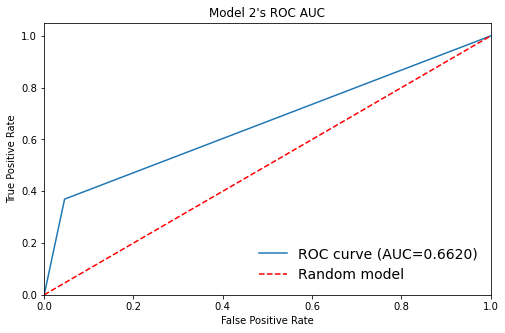

scoring=['precision', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   21.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


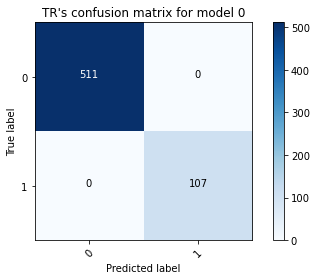

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


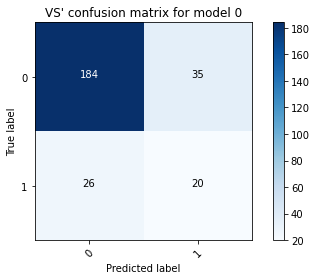

Parameters model 0 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


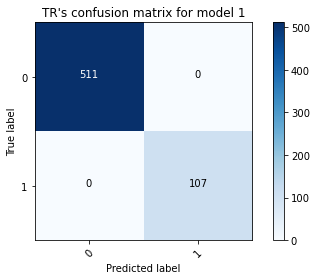

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


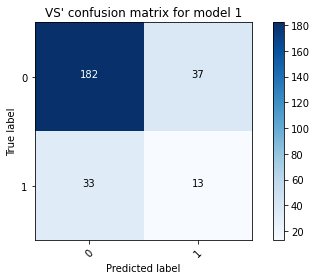

Parameters model 1 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


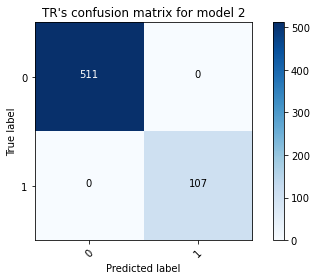

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


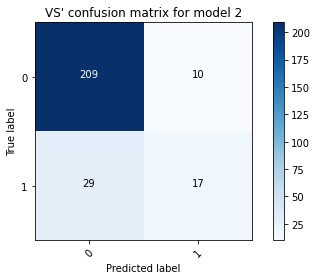

Parameters model 2 and resampling_label=scoring=['precision', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


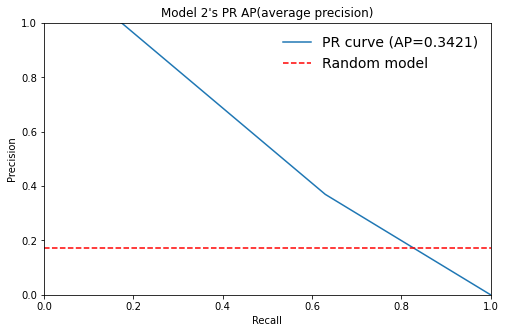

 Best Threshold=1.000000 


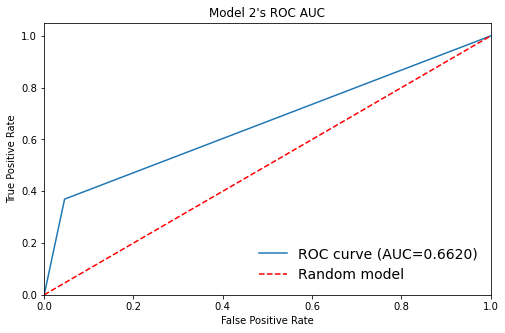

scoring=['roc_auc', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   19.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   20.1s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


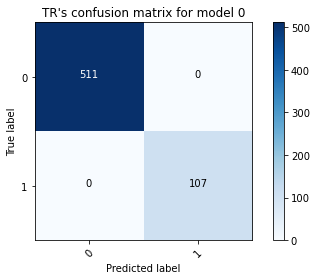

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


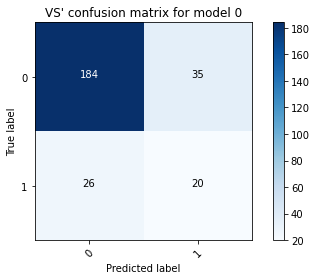

Parameters model 0 and resampling_label=scoring=['roc_auc', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


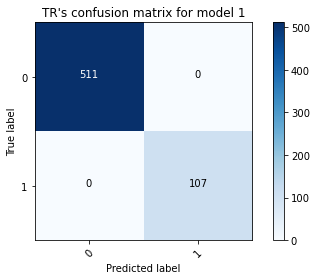

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


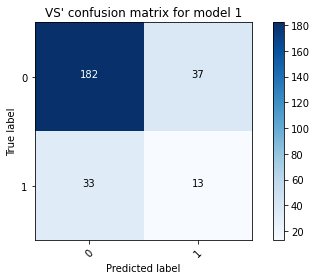

Parameters model 1 and resampling_label=scoring=['roc_auc', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


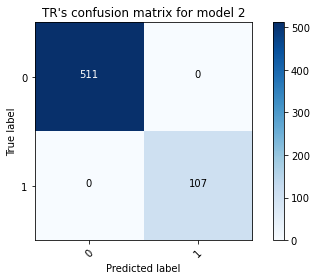

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


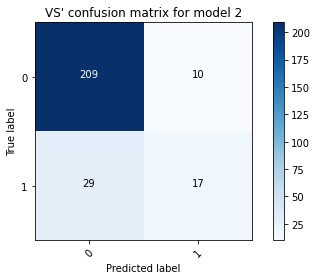

Parameters model 2 and resampling_label=scoring=['roc_auc', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


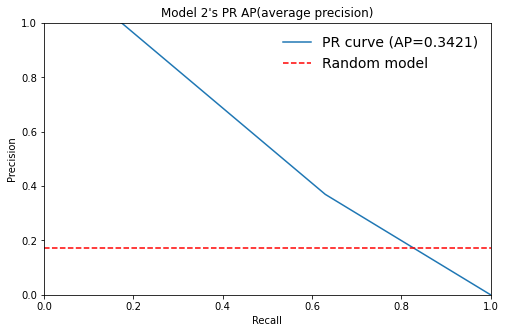

 Best Threshold=1.000000 


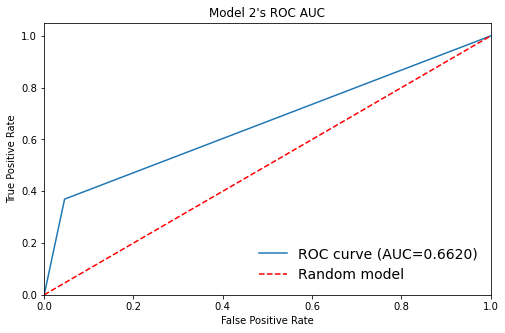

scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   22.9s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


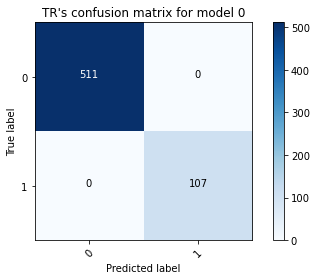

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


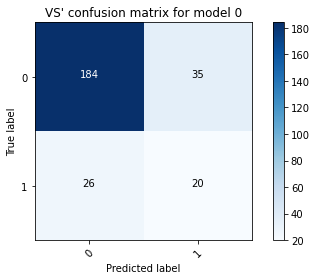

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


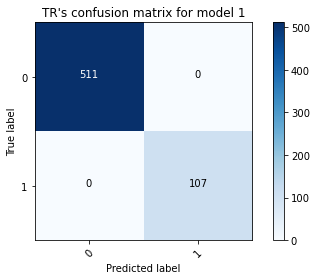

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


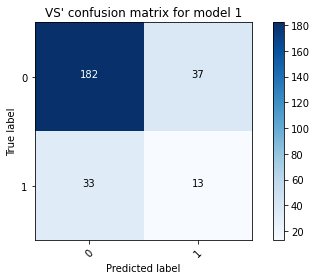

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


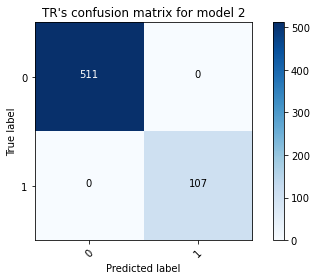

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


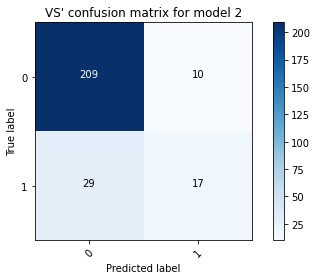

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


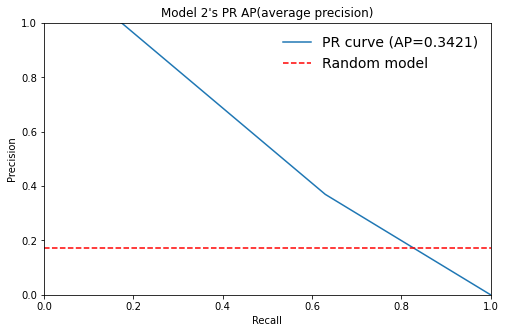

 Best Threshold=1.000000 


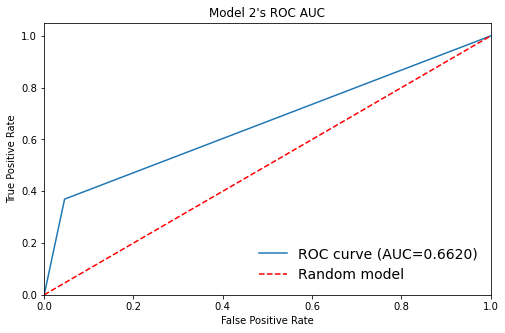

scoring=['f1', 'roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   20.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   20.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


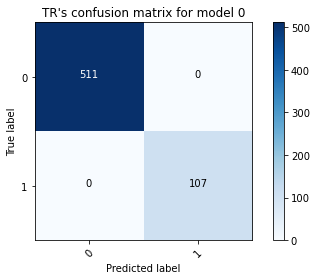

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


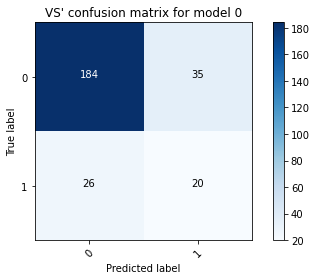

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


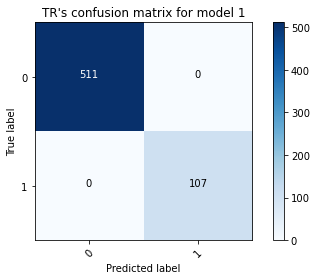

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


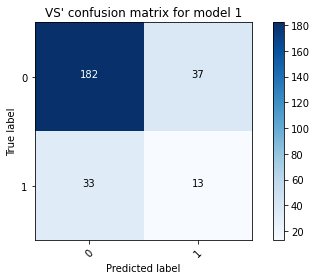

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


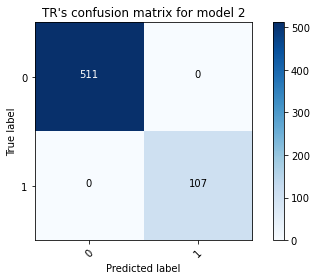

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


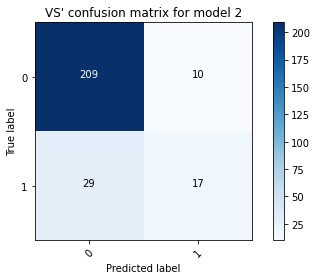

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'f1_weighted', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


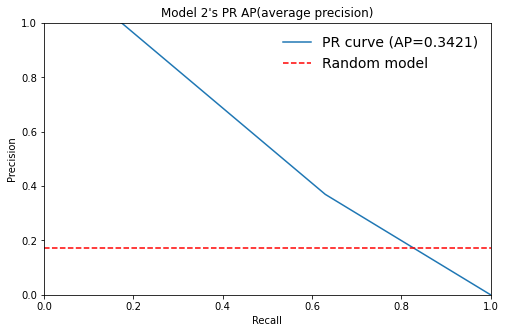

 Best Threshold=1.000000 


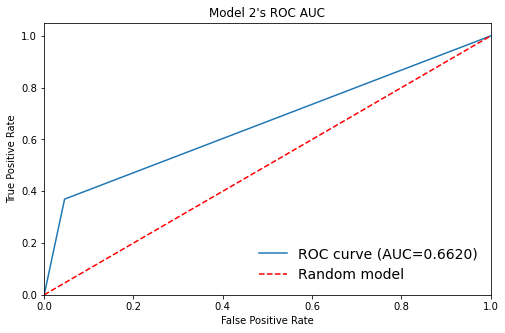

scoring=['f1', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   10.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   10.5s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


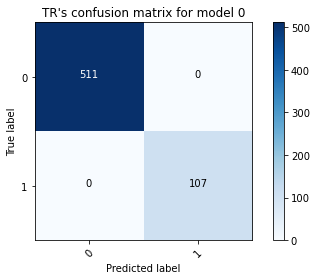

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


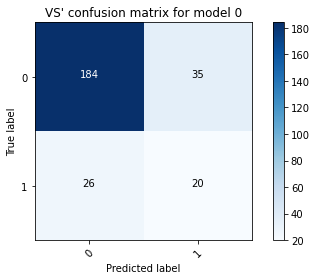

Parameters model 0 and resampling_label=scoring=['f1', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


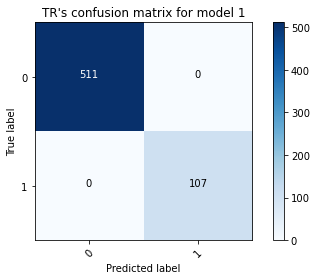

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


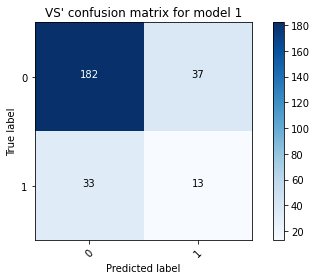

Parameters model 1 and resampling_label=scoring=['f1', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


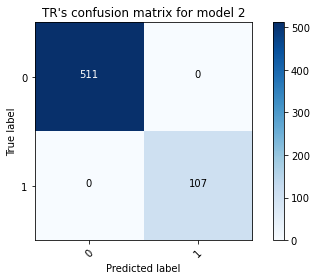

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


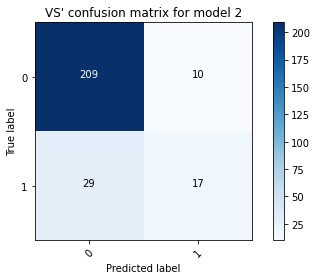

Parameters model 2 and resampling_label=scoring=['f1', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


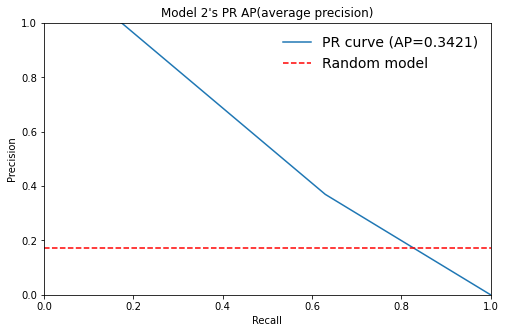

 Best Threshold=1.000000 


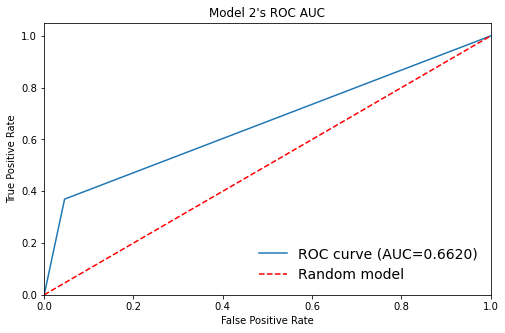

scoring=['roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   19.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


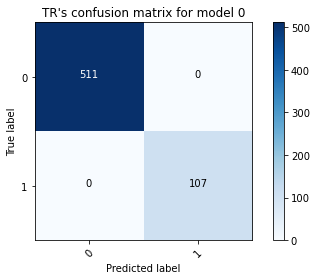

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


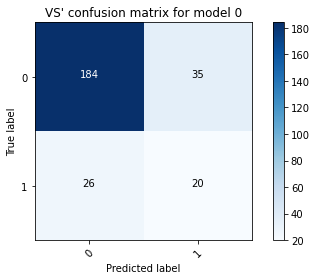

Parameters model 0 and resampling_label=scoring=['roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


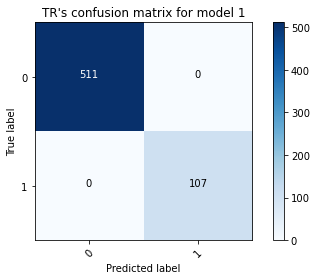

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


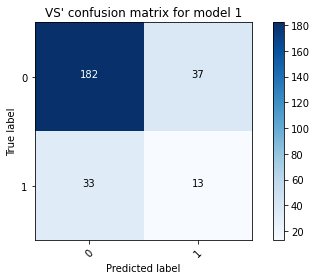

Parameters model 1 and resampling_label=scoring=['roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


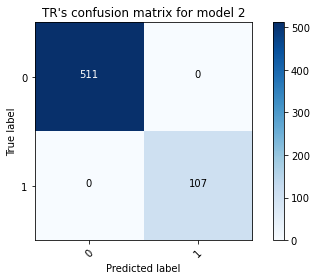

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


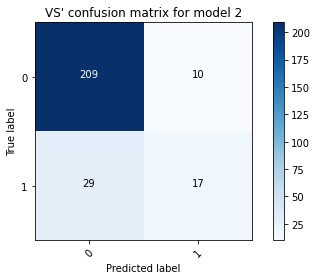

Parameters model 2 and resampling_label=scoring=['roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


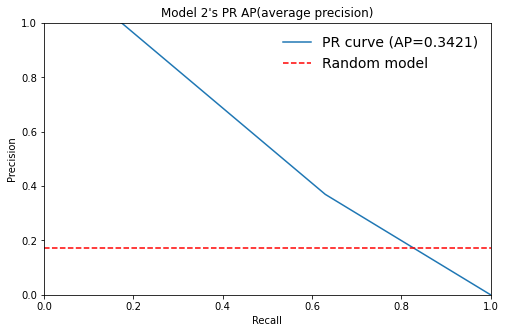

 Best Threshold=1.000000 


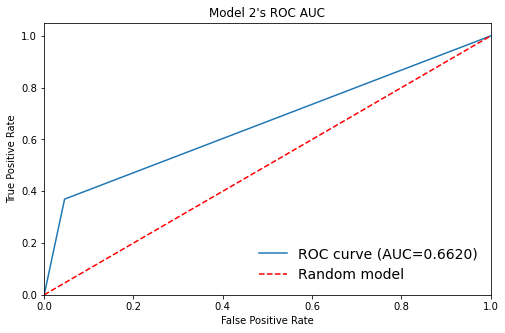

scoring=['f1', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   15.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


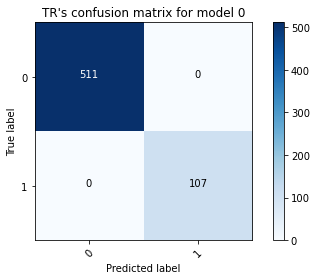

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


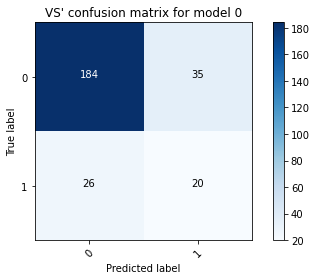

Parameters model 0 and resampling_label=scoring=['f1', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


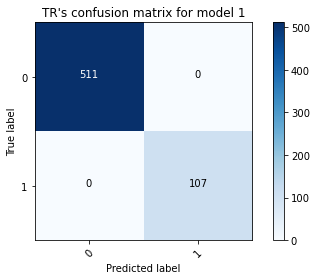

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


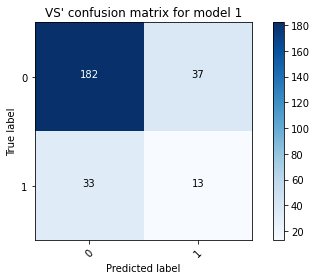

Parameters model 1 and resampling_label=scoring=['f1', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


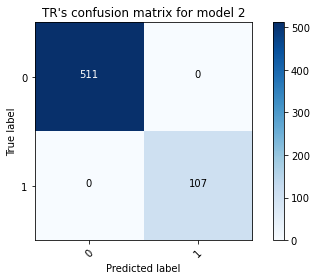

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


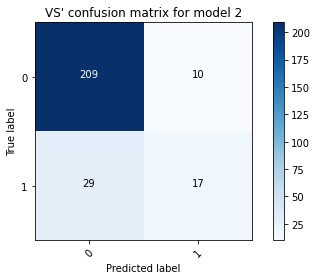

Parameters model 2 and resampling_label=scoring=['f1', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


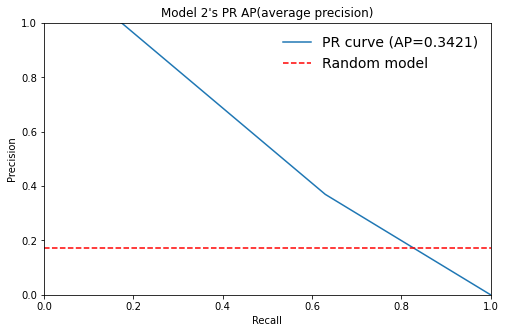

 Best Threshold=1.000000 


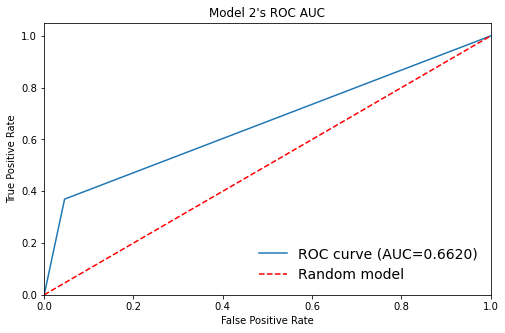

scoring=['f1', 'roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.3s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


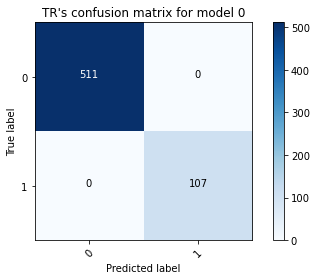

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


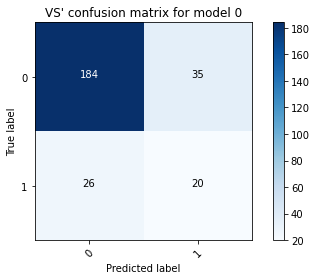

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


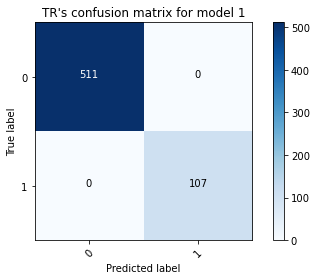

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


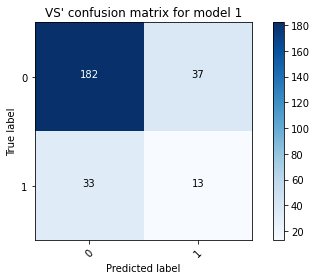

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


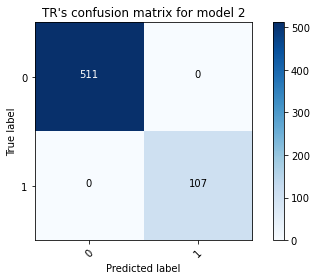

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


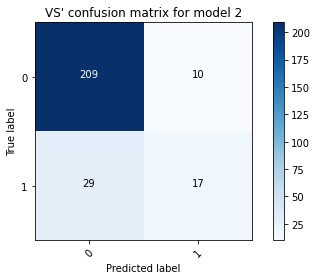

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


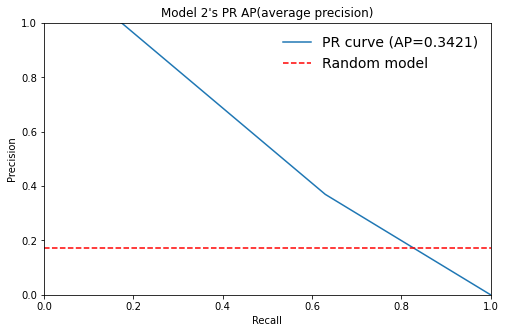

 Best Threshold=1.000000 


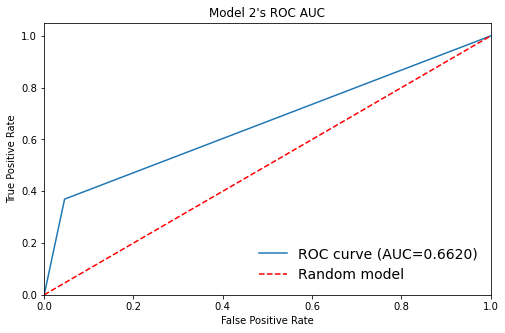

scoring=['roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   23.4s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


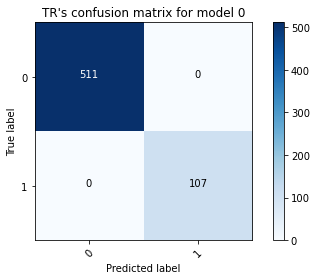

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


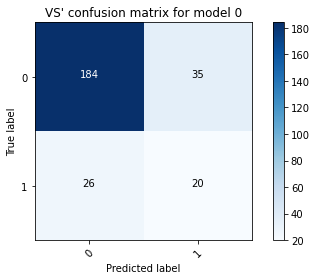

Parameters model 0 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


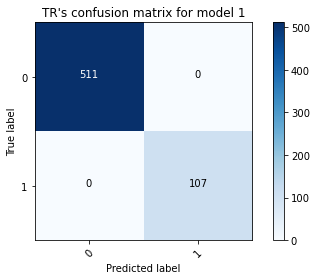

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


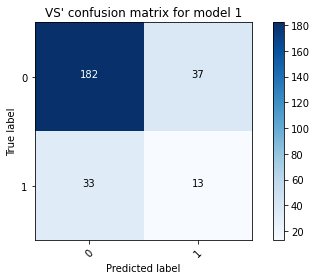

Parameters model 1 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


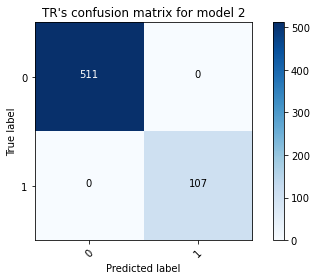

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


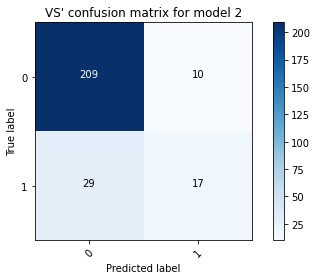

Parameters model 2 and resampling_label=scoring=['roc_auc', 'f1_weighted', 'average_precision', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


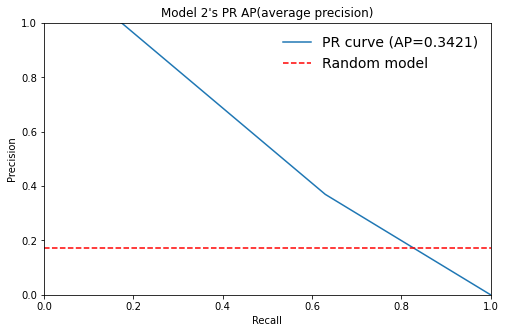

 Best Threshold=1.000000 


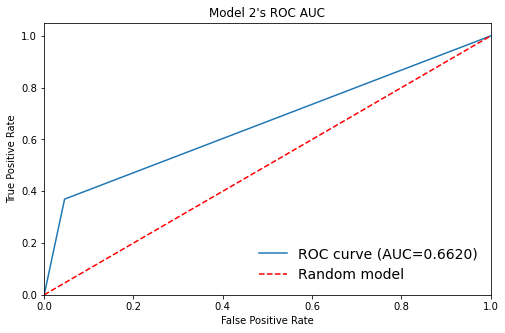

scoring=['roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   26.2s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


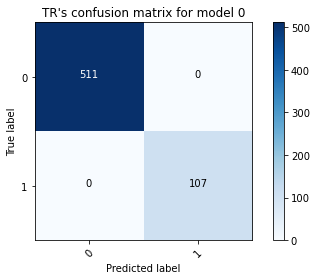

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


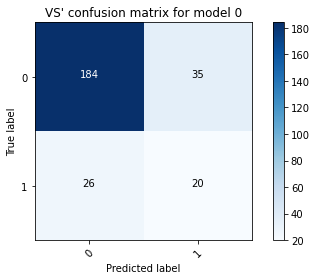

Parameters model 0 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


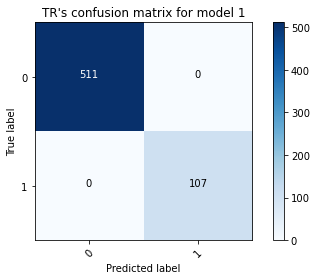

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


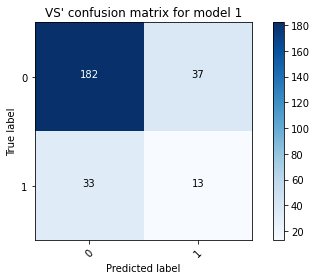

Parameters model 1 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


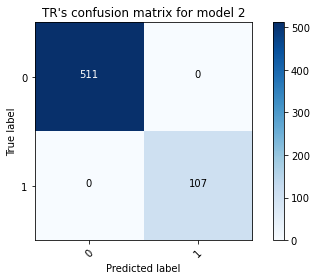

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


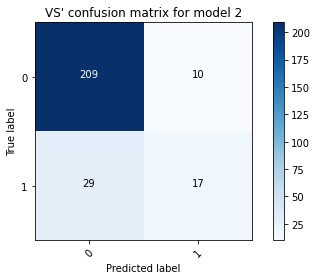

Parameters model 2 and resampling_label=scoring=['roc_auc', 'precision', 'f1_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


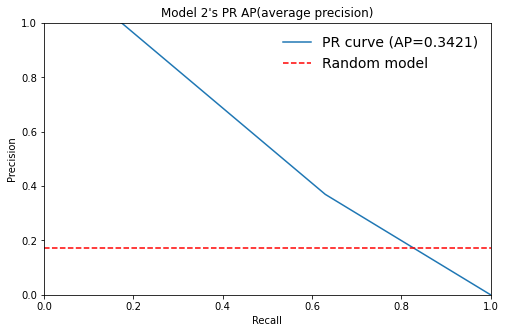

 Best Threshold=1.000000 


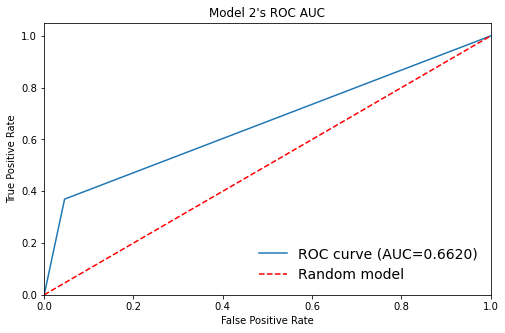

scoring=['precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 573 out of 588 | elapsed:   25.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   25.8s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


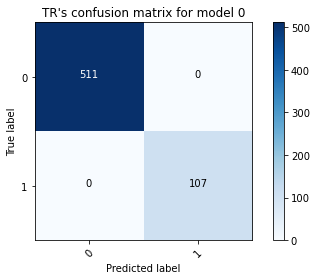

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


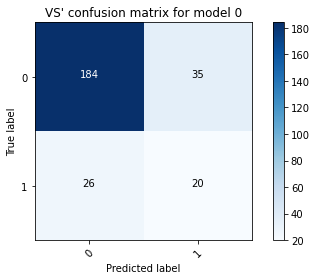

Parameters model 0 and resampling_label=scoring=['precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


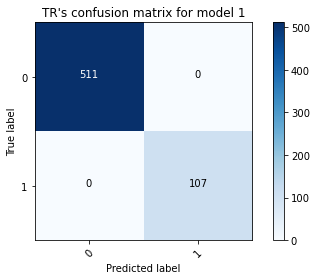

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


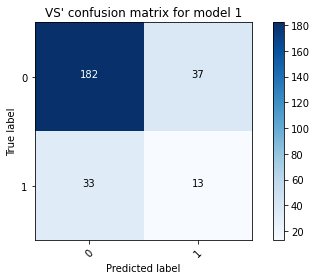

Parameters model 1 and resampling_label=scoring=['precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


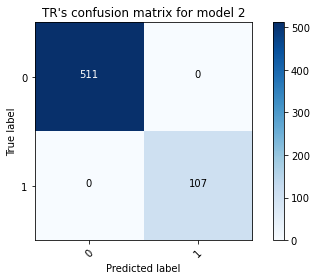

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


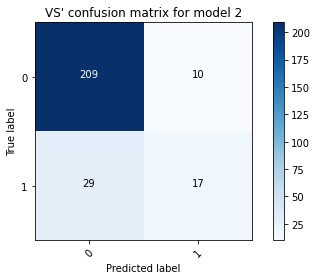

Parameters model 2 and resampling_label=scoring=['precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


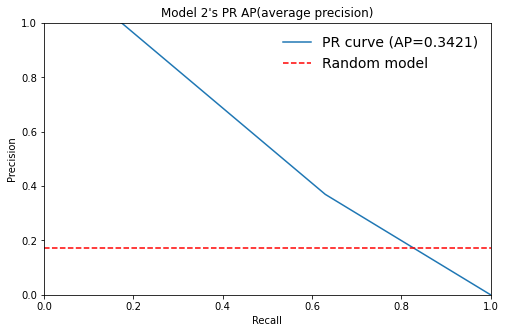

 Best Threshold=1.000000 


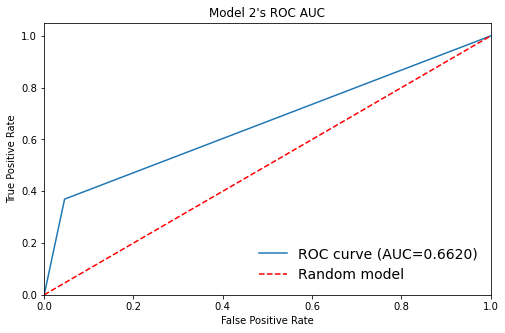

scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
Fitting 3 folds for each of 196 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:   27.7s finished


model 0
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


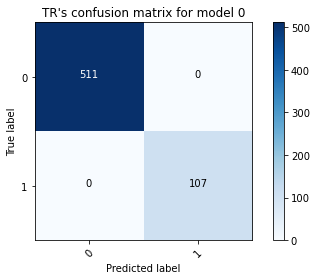

Validation roc_auc: 0.6374826285487393
Validation precision_recall_ap: 0.2562159743455888

Validation Accuracy 0.769811320754717
Validation Precision 0.787218818916932
Validation Recall 0.769811320754717
Validation F1-score 0.7776526854427097
Validation F2-score 0.772723486049582
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       219
           1       0.36      0.43      0.40        46

    accuracy                           0.77       265
   macro avg       0.62      0.64      0.63       265
weighted avg       0.79      0.77      0.78       265

Confusion matrix, without normalization
[[184  35]
 [ 26  20]]


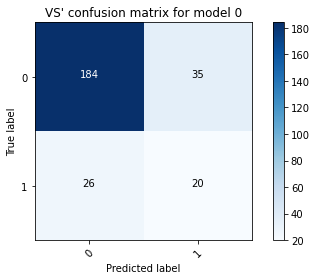

Parameters model 0 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=1"
model 1
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


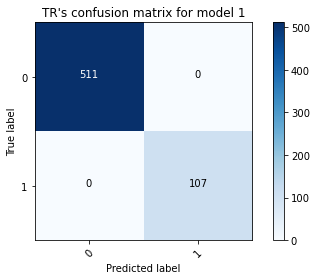

Validation roc_auc: 0.5568294619813381
Validation precision_recall_ap: 0.19800656275635767

Validation Accuracy 0.7358490566037735
Validation Precision 0.7447020623080299
Validation Recall 0.7358490566037735
Validation F1-score 0.7401349158044228
Validation F2-score 0.737528511338241
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       219
           1       0.26      0.28      0.27        46

    accuracy                           0.74       265
   macro avg       0.55      0.56      0.55       265
weighted avg       0.74      0.74      0.74       265

Confusion matrix, without normalization
[[182  37]
 [ 33  13]]


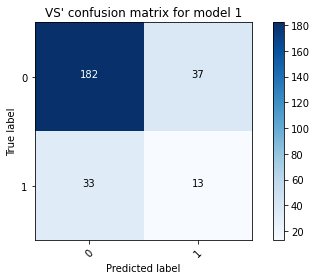

Parameters model 1 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=2, weights=distance, p=2"
model 2
Train Accuracy 1.0
Train Precision 1.0
Train Recall 1.0
Train F1-score 1.0
Train F2-score 1.0
Train roc_auc: 1.0
Confusion matrix, without normalization
[[511   0]
 [  0 107]]


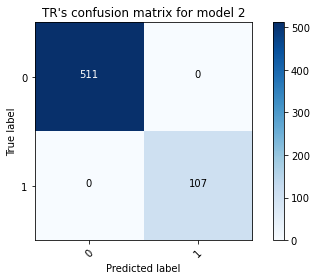

Validation roc_auc: 0.6619515584673417
Validation precision_recall_ap: 0.34212317321423147

Validation Accuracy 0.8528301886792453
Validation Precision 0.8350116566542759
Validation Recall 0.8528301886792453
Validation F1-score 0.8367372816411435
Validation F2-score 0.8451553725671387
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       219
           1       0.63      0.37      0.47        46

    accuracy                           0.85       265
   macro avg       0.75      0.66      0.69       265
weighted avg       0.84      0.85      0.84       265

Confusion matrix, without normalization
[[209  10]
 [ 29  17]]


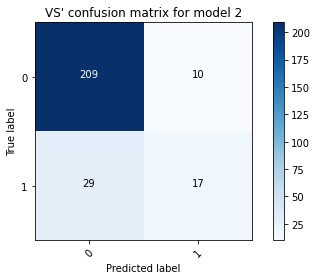

Parameters model 2 and resampling_label=scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall: n_neighbors=4, weights=distance, p=1"
model 0 - precision_recall_ap: 0.2562159743455888
model 1 - precision_recall_ap: 0.19800656275635767
model 2 - precision_recall_ap: 0.34212317321423147

BEST MODEL INDEX = 2
model 0 - roc_auc: 0.6374826285487393
model 1 - roc_auc: 0.5568294619813381
model 2 - roc_auc: 0.6619515584673417

BEST MODEL INDEX = 2
ModelThreshold=0.494, F-measure=0.51948 
 Best Threshold=1.000000, F-measure=0.466 


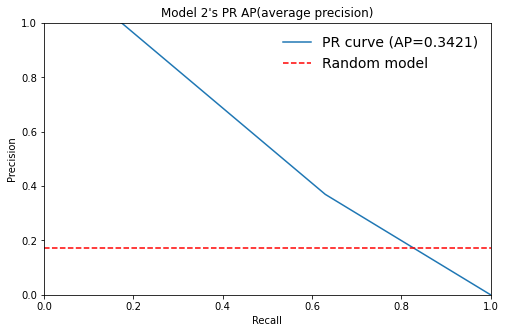

 Best Threshold=1.000000 


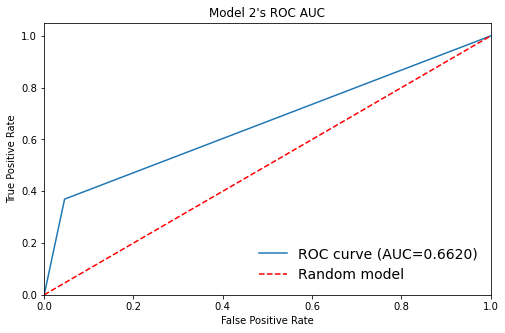

In [22]:
for scoring in scoring_sets:
    scoring = list(scoring) 
    for refit in refit_pool:
        resampling_label = "scoring=" + str(scoring) + "refit=" + str(refit)
        print(resampling_label)
        models_u, roc_auc_models_u_val, precision_recall_auc_models_u_val, best_model_index_u, best_ap_model_index_u  = \
                                                        my_grid_search("", resampling_label, scoring, "recall")
        break

In [23]:
max_roc_auc_key = ""
max_roc_auc_mode_index = -1
max_roc_auc_value = -1

max_ap_key = ""
max_ap_model_index = -1
max_ap = -1
for key, value, in sampling_methods_info.items():
    roc_auc_best_model_index = sampling_methods_info[key]["roc_auc_best_model_index"]
    if sampling_methods_info[key]["roc_auc"][roc_auc_best_model_index] >= max_roc_auc_value:
        max_roc_auc_value = sampling_methods_info[key]["roc_auc"][roc_auc_best_model_index]
        max_roc_auc_mode_index = roc_auc_best_model_index
        max_roc_auc_key = key
        
    ap_best_model_index = sampling_methods_info[key]["ap_best_model_index"]
    if sampling_methods_info[key]["ap"][ap_best_model_index] >= max_ap:
        max_ap = sampling_methods_info[key]["ap"][ap_best_model_index]
        max_ap_model_index = ap_best_model_index
        max_ap_key = key
        
print("max_roc_auc_key", max_roc_auc_key)
print("max_roc_auc_mode_index", max_roc_auc_mode_index)
print("max_roc_auc", max_roc_auc_value)
print()
print("max_ap_model_index", max_ap_model_index)
print("max_ap_key", max_ap_key)
print("max_ap", max_ap)

max_roc_auc_key scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
max_roc_auc_mode_index 2
max_roc_auc 0.6619515584673417

max_ap_model_index 2
max_ap_key scoring=['f1', 'roc_auc', 'precision', 'average_precision', 'roc_auc_ovo_weighted', 'recall']refit=recall
max_ap 0.34212317321423147
